# Autoencoders: Learning Compact Representations

<div>
<h2 style="margin: 0;">Learning Objectives</h2>
<ul style="margin: 10px 0;">
<li>Understand the architecture and working principles of autoencoders</li>
<li>Implement and train simple and convolutional autoencoders</li>
<li>Explore latent space representations and their properties</li>
<li>Apply autoencoders for denoising and outlier detection</li>
<li>Visualize and interpret learned representations</li>
</ul>
</div>

## Table of Contents
1. Setup & Data Loading
2. Simple Autoencoder
3. Denoising Autoencoder
4. Convolutional Autoencoder
5. Latent Space Exploration
6. Exercises

<div>
<p style="margin: 0;">
<strong>CAS on Advanced Machine Learning</strong><br>
Data Science Lab, University of Bern, 2025<br>
Prepared by Dr. Mykhailo Vladymyrov and Matteo Boi
</p>
</div>

<div style="text-align: center; margin: 20px 0;">

<strong>Autoencoder architecture</strong><br>

<img src="https://contenthub-static.grammarly.com/blog/wp-content/uploads/2024/10/6303_blog-visuals-auto-encoders_1500X800.png" alt="Autoencoder Concept" style="width: 800px; height: auto; border-radius: 10px;">

Figure from <a href="https://www.grammarly.com/blog/ai/what-is-autoencoder/">Grammarly</a>.
</div>

---

This work is licensed under a <a href="https://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

# Libraries and Utilities

<div>
<strong>Note:</strong> We'll be using PyTorch for implementing autoencoders, along with visualization libraries for better understanding of the learned representations.
</div>

In [1]:
!pip install einops
!pip install mlflow
!pip install optuna

In [2]:
# Additional packages for interactive widgets
!pip install ipywidgets
!pip install plotly
!pip install umap-learn

In [3]:
import os

# set env var to allow duplicated lib
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import einops as eo
import pathlib as pl

import matplotlib.cm as cm
from matplotlib import collections  as mc
from matplotlib import animation
%matplotlib inline

from scipy.stats import norm
from scipy.stats import entropy
from scipy.ndimage import uniform_filter1d

import pandas as pd
import pickle
from PIL import Image
from time import time as timer
#import umap

from IPython.display import HTML
from IPython.display import Audio
import IPython

import tqdm.auto as tqdm
from functools import partial

import torch
from torchvision import datasets, transforms
from torch import nn
from torch import optim
import torch.nn.functional as F

import sys
is_colab = 'google.colab' in sys.modules

In [5]:
# Plotting Configuration
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

plt.rcParams.update({
    'figure.figsize': (10, 6),
    'axes.titlesize': 16,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 18,
    'lines.linewidth': 2,
    'axes.grid': True,
    'grid.alpha': 0.3
})

COLORS = {
    'encoder': '#FF6B6B',
    'decoder': '#4ECDC4',
    'latent': '#45B7D1',
    'original': '#96CEB4',
    'reconstructed': '#FECA57',
    'noisy': '#FF9FF3'
}

In [6]:
# Interactive Widgets Setup
import ipywidgets as widgets
from IPython.display import display, clear_output
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

def create_interactive_latent_explorer(model, samples, device):
    """
    Create interactive widget to explore latent space
    """

    # Extract data
    sample_images = torch.tensor(samples['images']).to(device)
    labels = samples['labels']

    # Get latent representations
    with torch.no_grad():
        latent_codes = model.encode(sample_images)
        latent_np = latent_codes.cpu().numpy()

    # Create sliders for each latent dimension
    if latent_codes.shape[1] >= 2:
        slider1 = widgets.FloatSlider(value=0, min=-6, max=6, step=0.1, description='Latent 1:')
        slider2 = widgets.FloatSlider(value=0, min=-6, max=6, step=0.1, description='Latent 2:')

        output = widgets.Output()

        def update_plot(change):
            with output:
                clear_output(wait=True)

                # Create latent vector
                z = torch.zeros(1, latent_codes.shape[1]).to(device)
                z[0, 0] = slider1.value
                z[0, 1] = slider2.value

                # Generate image
                with torch.no_grad():
                    generated = model.decode(z)
                    img = to_np_showable(generated[0])

                # Plot
                fig, ax = plt.subplots(figsize=(6, 6))
                ax.imshow(img, cmap='gray')
                ax.set_title(f'Generated Image\\nLatent: [{slider1.value:.1f}, {slider2.value:.1f}]',
                           fontsize=14)
                ax.axis('off')
                plt.show()

        slider1.observe(update_plot, names='value')
        slider2.observe(update_plot, names='value')

        # Initial plot
        update_plot(None)

        return widgets.VBox([
            widgets.HTML("<h3> Interactive Latent Space Explorer</h3>"),
            widgets.HTML("<p>Move the sliders to explore what the decoder generates!</p>"),
            slider1, slider2, output
        ])

    return widgets.HTML("<p>Interactive explorer requires at least 2 latent dimensions</p>")

def create_noise_comparison_widget():
    """
    Create widget to interactively compare different noise levels
    """

    noise_slider = widgets.FloatSlider(
        value=0.2, min=0.0, max=0.8, step=0.1,
        description='Noise Rate:', style={'description_width': 'initial'}
    )

    output = widgets.Output()

    def update_noise_demo(change):
        with output:
            clear_output(wait=True)

            # Create demo with current noise rate
            noise_rate = noise_slider.value

            # Simulate noisy image (using a sample from your data)
            sample_idx = 42  # Fixed sample for consistency
            original_img = samples['images'][sample_idx, 0]  # Assuming samples is available

            # Add noise
            noise_mask = np.random.binomial(1, noise_rate, original_img.shape)
            sp_noise = np.random.binomial(1, 0.5, original_img.shape) - 0.5
            noisy_img = original_img * (1 - noise_mask) + sp_noise * noise_mask

            # Plot comparison
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))

            axes[0].imshow(original_img, cmap='gray')
            axes[0].set_title('Original Image', fontsize=14)
            axes[0].axis('off')

            axes[1].imshow(noisy_img, cmap='gray')
            axes[1].set_title(f'Noisy Image (rate={noise_rate:.1f})', fontsize=14)
            axes[1].axis('off')

            plt.suptitle('Effect of Different Noise Levels', fontsize=16)
            plt.tight_layout()
            plt.show()

    noise_slider.observe(update_noise_demo, names='value')
    update_noise_demo(None)  # Initial plot

    return widgets.VBox([
        widgets.HTML("<h3> Interactive Noise Level Demo</h3>"),
        noise_slider, output
    ])

In [7]:
# get mean and std of an array with numpy:
def get_mean_std(x):
    x_mean = np.mean(x)
    x_std = np.std(x)
    return x_mean, x_std

# get min and max of an array with numpy:
def get_min_max(x):
    x_min = np.min(x)
    x_max = np.max(x)
    return x_min, x_max

def is_iterable(obj):
    try:
        iter(obj)
    except Exception:
        return False
    else:
        return True

def type_len(obj):
    t = type(obj)
    if is_iterable(obj):
        sfx = f', shape: {obj.shape}' if t == np.ndarray else ''
        print(f'type: {t}, len: {len(obj)}{sfx}')
    else:
        print(f'type: {t}, len: {len(obj)}')

In [8]:
# Image Visualization Functions

def to_np_showable(pt_img):
    """Convert PyTorch tensor to displayable numpy array"""
    np_im = pt_img.detach().cpu().numpy()
    if len(np_im.shape) == 4:
        np_im = np_im[0]
    if np_im.shape[0] > 3:
        np_im = np_im[-3:]
    return (eo.rearrange(np_im, 'c h w -> h w c')/2+.5).clip(0., 1.)

def plot_im(im, title="Image", is_torch=True, figsize=(6, 6)):
    """Plot a single image with enhanced styling"""
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(to_np_showable(im) if is_torch else im, cmap='gray')
    ax.set_title(title, fontsize=14, pad=15)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

def plot_im_samples(ds, n=5, is_torch=False, title="Sample Images", figsize=None):
    """Plot multiple images in a row with enhanced styling"""
    if figsize is None:
        figsize = (3*n, 4)

    fig, axs = plt.subplots(1, n, figsize=figsize)
    fig.suptitle(title, fontsize=16, y=1.02)

    if n == 1:
        axs = [axs]

    for i, image in enumerate(ds[:n]):
        axs[i].imshow(to_np_showable(image) if is_torch else image, cmap='gray')
        axs[i].set_title(f'Sample {i+1}', fontsize=12)
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

def plot_comparison(original, reconstructed, noisy=None, titles=None, figsize=(15, 5)):
    """Plot comparison between original, noisy (if provided), and reconstructed images"""
    images = [original, reconstructed]
    default_titles = ['Original', 'Reconstructed']

    if noisy is not None:
        images.insert(1, noisy)
        default_titles = ['Original', 'Noisy Input', 'Reconstructed']

    if titles is None:
        titles = default_titles

    n_imgs = len(images)
    fig, axs = plt.subplots(1, n_imgs, figsize=figsize)

    colors = [COLORS['original'], COLORS['noisy'], COLORS['reconstructed']][:n_imgs]

    for i, (img, title, color) in enumerate(zip(images, titles, colors)):
        axs[i].imshow(to_np_showable(img), cmap='gray')
        axs[i].set_title(title, fontsize=14, color=color, fontweight='bold')
        axs[i].axis('off')

        # Add colored border
        for spine in axs[i].spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(3)
            spine.set_visible(True)

    plt.tight_layout()
    plt.show()

In [9]:
def mosaic(mtr_of_ims, spacing=2, background_color=0.8):
    """
    Create a mosaic from a 2D matrix of images with enhanced styling

    Args:
        mtr_of_ims: 2D list/array of images
        spacing: pixels between images
        background_color: color for spacing between images
    """
    ny = len(mtr_of_ims)
    assert(ny != 0)

    nx = len(mtr_of_ims[0])
    assert(nx != 0)

    im_sh = mtr_of_ims[0][0].shape
    assert (2 <= len(im_sh) <= 3)
    multichannel = len(im_sh) == 3

    if multichannel:
        h, w, c = im_sh
    else:
        h, w = im_sh

    h_c = h * ny + spacing * (ny-1)
    w_c = w * nx + spacing * (nx-1)

    canv_sh = (h_c, w_c, c) if multichannel else (h_c, w_c)
    canvas = np.ones(shape=canv_sh, dtype=np.float32) * background_color

    for iy, row in enumerate(mtr_of_ims):
        y_ofs = iy * (h + spacing)
        for ix, im in enumerate(row):
            x_ofs = ix * (w + spacing)
            canvas[y_ofs:y_ofs + h, x_ofs:x_ofs + w] = im

    return canvas

def create_progress_mosaic(images_list, labels=None, title="Training Progress", figsize=(15, 10)):
    """Create an enhanced mosaic showing training progress"""
    mosaic_img = mosaic(images_list, spacing=3, background_color=0.9)

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(mosaic_img, cmap='gray', vmin=0, vmax=1)

    ax.set_title(title, fontsize=18, pad=20, fontweight='bold')

    # Add labels if provided
    if labels is not None:
        ax.set_ylabel(' | '.join(labels), fontsize=14, rotation=0, ha='right', va='center')

    ax.axis('off')

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Pixel Intensity', fontsize=12)

    plt.tight_layout()
    plt.show()

In [10]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')  # use first available GPU
    else:
        device = torch.device('cpu')
    return device

In [11]:
def visualize_reconstruction_quality_analysis(model, samples, device):
    """
    Analyze reconstruction quality across different digits and show failure cases
    """
    model.eval()
    with torch.no_grad():
        images = torch.tensor(samples['images']).to(device)
        labels = samples['labels']

        reconstructions = model(images)

        # reconstruction errors
        mse_errors = F.mse_loss(reconstructions, images, reduction='none')
        mse_errors = mse_errors.view(len(images), -1).mean(dim=1).cpu().numpy()

        fig = plt.figure(figsize=(15, 3))
        plt.title('Reconstruction Quality Analysis', fontsize=14)

        # error distribution by digit class
        digit_errors = {}
        for digit in range(10):
            mask = labels == digit
            digit_errors[digit] = mse_errors[mask]

        plt.boxplot([digit_errors[i] for i in range(10)], tick_labels=range(10))
        plt.title('Reconstruction Error by Digit Class')
        plt.xlabel('Digit Class')
        plt.ylabel('MSE Error')
        plt.tight_layout()
        plt.show()

        best_indices = np.argsort(mse_errors)[:5]
        fig, axes = plt.subplots(1, 5, figsize=(15, 3))
        fig.suptitle('Best Reconstructions', fontsize=14)

        for i, idx in enumerate(best_indices):
            orig_img = images[idx, 0].cpu().numpy()
            recon_img = reconstructions[idx, 0].cpu().numpy()
            comparison = np.hstack([orig_img, recon_img])
            axes[i].imshow(comparison, cmap='gray')
            axes[i].set_title(f'Digit: {labels[idx]}\nError: {mse_errors[idx]:.4f}')
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()

        worst_indices = np.argsort(mse_errors)[-5:]
        fig, axes = plt.subplots(1, 5, figsize=(15, 3))
        fig.suptitle('Worst Reconstructions', fontsize=14)

        for i, idx in enumerate(worst_indices):
            orig_img = images[idx, 0].cpu().numpy()
            recon_img = reconstructions[idx, 0].cpu().numpy()
            comparison = np.hstack([orig_img, recon_img])
            axes[i].imshow(comparison, cmap='gray')
            axes[i].set_title(f'Digit: {labels[idx]}\nError: {mse_errors[idx]:.4f}')
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()

In [12]:
# Architecture Visualization Functions

def visualize_autoencoder_architecture(model, input_shape):
    """
    Create a visual representation of the autoencoder architecture
    """
    fig, ax = plt.subplots(1, 1, figsize=(20, 8))

    # layer information
    encoder_layers = []
    decoder_layers = []

    # encoder
    for name, layer in model.encoder.named_children():
        if isinstance(layer, nn.Linear):
            encoder_layers.append(('Linear', layer.in_features, layer.out_features))
        elif isinstance(layer, nn.Conv2d):
            encoder_layers.append(('Conv2d', f'{layer.in_channels}ch ({layer.kernel_size[0]}×{layer.kernel_size[0]})k\n',
                                 f'{layer.out_channels}ch'))
        elif isinstance(layer, nn.Flatten):
            encoder_layers.append(('Flatten', '', ''))

    # decoder
    for name, layer in model.decoder.named_children():
        if isinstance(layer, nn.Linear):
            decoder_layers.append(('Linear', layer.in_features, layer.out_features))
        elif isinstance(layer, nn.ConvTranspose2d):
            decoder_layers.append(('ConvTran2d', f'{layer.in_channels}ch',
                                 f'\n{layer.out_channels}ch ({layer.kernel_size[0]}×{layer.kernel_size[0]})k'))
        elif isinstance(layer, nn.Unflatten):
            decoder_layers.append(('Unflatten', '', ''))

    y_pos = 0.5
    # positions for input + encoder + latent + decoder + output
    total_positions = 1 + len(encoder_layers) + 1 + len(decoder_layers) + 1
    x_positions = np.linspace(0.1, 0.9, total_positions)

    # box dimensions
    box_width = 0.035
    box_height = 0.15
    latent_width = 0.045
    latent_height = 0.2

    # Input
    ax.add_patch(plt.Rectangle((x_positions[0]-box_width/2, y_pos-box_height/2), box_width, box_height,
                              facecolor='lightblue', edgecolor='black'))
    ax.text(x_positions[0], y_pos+box_height/2+0.05, 'Input\n' + '×'.join(map(str, input_shape[1:])),
            ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Encoder layers
    for i, (layer_type, in_dim, out_dim) in enumerate(encoder_layers):
        x = x_positions[i+1]
        color = 'lightcoral' if 'Conv' in layer_type else 'lightgreen'

        ax.add_patch(plt.Rectangle((x-box_width/2, y_pos-box_height/2), box_width, box_height,
                                  facecolor=color, edgecolor='black'))
        ax.text(x, y_pos+box_height/2+0.05, f'{layer_type}\n{in_dim} → {out_dim}',
                ha='center', va='bottom', fontsize=9)

        # arrows
        prev_x = x_positions[i]
        arrow_start_x = prev_x + box_width/2
        arrow_end_x = x - box_width/2
        ax.arrow(arrow_start_x, y_pos, arrow_end_x - arrow_start_x - 0.008, 0,
                head_width=0.025, head_length=0.008, fc='black', ec='black')

    # Latent space
    bottleneck_x = x_positions[len(encoder_layers)+1]
    ax.add_patch(plt.Rectangle((bottleneck_x-latent_width/2, y_pos-latent_height/2), latent_width, latent_height,
                              facecolor='gold', edgecolor='red', linewidth=2))
    ax.text(bottleneck_x, y_pos+latent_height/2+0.05, f'Latent\n{model.code_size}D',
            ha='center', va='bottom', fontsize=11, fontweight='bold', color='red')

    # arrows to latent space
    prev_x = x_positions[len(encoder_layers)]
    arrow_start_x = prev_x + box_width/2
    arrow_end_x = bottleneck_x - latent_width/2
    ax.arrow(arrow_start_x, y_pos, arrow_end_x - arrow_start_x - 0.008, 0,
             head_width=0.025, head_length=0.008, fc='black', ec='black')

    # Decoder layers
    for i, (layer_type, in_dim, out_dim) in enumerate(decoder_layers):
        x = x_positions[len(encoder_layers) + 2 + i]
        color = 'lightcoral' if 'Conv' in layer_type else 'lightgreen'

        ax.add_patch(plt.Rectangle((x-box_width/2, y_pos-box_height/2), box_width, box_height,
                                  facecolor=color, edgecolor='black'))
        ax.text(x, y_pos+box_height/2+0.05, f'{layer_type}\n{in_dim} → {out_dim}',
                ha='center', va='bottom', fontsize=9)

        # arrows
        if i == 0:
            # Arrow from latent space to first decoder layer
            arrow_start_x = bottleneck_x + latent_width/2
            arrow_end_x = x - box_width/2 - 0.008
        else:
            # Arrow from previous decoder layer
            prev_x = x_positions[len(encoder_layers) + 1 + i]
            arrow_start_x = prev_x + box_width/2
            arrow_end_x = x - box_width/2 - 0.008

        ax.arrow(arrow_start_x, y_pos, arrow_end_x - arrow_start_x, 0,
                head_width=0.025, head_length=0.008, fc='black', ec='black')

    # Output
    output_x = x_positions[-1]
    ax.add_patch(plt.Rectangle((output_x-box_width/2, y_pos-box_height/2), box_width, box_height,
                              facecolor='lightblue', edgecolor='black'))
    ax.text(output_x, y_pos+box_height/2+0.05, 'Output\n' + '×'.join(map(str, input_shape[1:])),
            ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Final arrow from last decoder layer to output
    prev_x = x_positions[-2]
    arrow_start_x = prev_x + box_width/2
    arrow_end_x = output_x - box_width/2 - 0.008
    ax.arrow(arrow_start_x, y_pos, arrow_end_x - arrow_start_x, 0,
            head_width=0.025, head_length=0.008, fc='black', ec='black')

    # labels
    ax.text(0.3, 0.1, 'ENCODER\n(Compression)', ha='center', va='center',
            fontsize=14, fontweight='bold', color='darkred',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='darkred'))

    ax.text(0.7, 0.1, 'DECODER\n(Reconstruction)', ha='center', va='center',
            fontsize=14, fontweight='bold', color='darkblue',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='darkblue'))

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title('Autoencoder Architecture', fontsize=18, fontweight='bold', pad=20)
    ax.axis('off')

    plt.tight_layout()
    plt.show()

def create_information_flow_diagram():
    """
    Create a conceptual diagram showing information flow and dimensionality
    """
    fig, ax = plt.subplots(1, 1, figsize=(14, 6))

    # Define the flow stages
    stages = [
        ('Raw Image', 784, 'lightblue'),
        ('Hidden Layer', 128, 'lightgreen'),
        ('Latent Code', 5, 'gold'),
        ('Hidden Layer', 128, 'lightgreen'),
        ('Reconstructed', 784, 'lightcoral')
    ]

    x_positions = np.linspace(0.1, 0.9, len(stages))

    for i, (name, size, color) in enumerate(stages):
        x = x_positions[i]

        # Draw rectangle with height proportional to dimensionality
        height = 0.1 + (size / 1000) * 0.6  # Scale height
        width = 0.08

        rect = plt.Rectangle((x - width/2, 0.5 - height/2), width, height,
                           facecolor=color, edgecolor='black', linewidth=2)
        ax.add_patch(rect)

        # Add labels
        ax.text(x, 0.5 + height/2 + 0.05, name, ha='center', va='bottom',
                fontsize=12, fontweight='bold')
        ax.text(x, 0.5, str(size), ha='center', va='center',
                fontsize=14, fontweight='bold')

        # Add arrows
        if i < len(stages) - 1:
            arrow_start = x + width/2
            arrow_end = x_positions[i+1] - width/2
            ax.arrow(arrow_start, 0.5, arrow_end - arrow_start, 0,
                    head_width=0.03, head_length=0.02, fc='black', ec='black')

    # Add compression/expansion labels
    ax.text(0.25, 0.15, 'COMPRESSION\\n(Information Bottleneck)', ha='center', va='center',
            fontsize=11, fontweight='bold', color='red',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='red'))

    ax.text(0.75, 0.15, 'EXPANSION\\n(Information Recovery)', ha='center', va='center',
            fontsize=11, fontweight='bold', color='blue',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='blue'))

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title('Information Flow: From 784 Dimensions to 5 and Back',
                fontsize=16, fontweight='bold')
    ax.axis('off')

    plt.tight_layout()
    plt.show()

In [13]:
# Latent Space Exploration Functions

def visualize_latent_interpolation_grid(model, device, latent_dim=2, n_steps=10, range_vals=(-3, 3)):
    """
    Create a comprehensive grid showing what happens when we interpolate in latent space
    """
    if latent_dim < 2:
        print(f"Need at least 2 latent dimensions for grid interpolation, got {latent_dim}")
        return

    model.eval()

    # Create a grid of latent values
    x_vals = np.linspace(range_vals[0], range_vals[1], n_steps)
    y_vals = np.linspace(range_vals[0], range_vals[1], n_steps)

    fig, axes = plt.subplots(n_steps, n_steps, figsize=(15, 15))
    fig.suptitle('Latent Space Grid Exploration\\n'
                f'Each image corresponds to a point (x,y) in the {latent_dim}D latent space',
                fontsize=16, fontweight='bold')

    with torch.no_grad():
        for i, y_val in enumerate(reversed(y_vals)):  # Reverse for correct orientation
            for j, x_val in enumerate(x_vals):
                # Create latent vector
                z = torch.zeros(1, latent_dim).to(device)
                z[0, 0] = x_val
                z[0, 1] = y_val

                # Generate image
                generated = model.decode(z)
                img = to_np_showable(generated[0])

                # Plot
                axes[i, j].imshow(img, cmap='gray')
                axes[i, j].axis('off')

                # Add coordinates as title for corner images
                if (i == 0 and j == 0) or (i == 0 and j == n_steps-1) or \
                   (i == n_steps-1 and j == 0) or (i == n_steps-1 and j == n_steps-1):
                    axes[i, j].set_title(f'({x_val:.1f},{y_val:.1f})', fontsize=8)

    # Add axis labels
    fig.text(0.5, 0.02, f'Latent Dimension 1 → ({range_vals[0]} to {range_vals[1]})',
             ha='center', fontsize=12)
    fig.text(0.02, 0.5, f'Latent Dimension 2 → ({range_vals[0]} to {range_vals[1]})',
             va='center', rotation='vertical', fontsize=12)

    plt.tight_layout()
    plt.show()

def visualize_digit_interpolation(model, samples, device, digit1=3, digit2=8, n_steps=8):
    """
    Show interpolation between two specific digits in latent space
    """
    model.eval()

    # Find examples of the two digits
    labels = samples['labels']
    images = samples['images']

    # Get indices for each digit
    digit1_indices = np.where(labels == digit1)[0]
    digit2_indices = np.where(labels == digit2)[0]

    if len(digit1_indices) == 0 or len(digit2_indices) == 0:
        print(f"Could not find examples of digits {digit1} and/or {digit2}")
        return

    # Select one example of each digit
    idx1 = digit1_indices[0]
    idx2 = digit2_indices[0]

    img1 = torch.tensor(images[idx1:idx1+1]).to(device)
    img2 = torch.tensor(images[idx2:idx2+1]).to(device)

    with torch.no_grad():
        # Get latent representations
        z1 = model.encode(img1)
        z2 = model.encode(img2)

        # Create interpolation
        alphas = np.linspace(0, 1, n_steps)
        interpolated_images = []

        for alpha in alphas:
            # Interpolate in latent space
            z_interp = (1 - alpha) * z1 + alpha * z2

            # Decode
            img_interp = model.decode(z_interp)
            interpolated_images.append(to_np_showable(img_interp[0]))

        # Visualize
        fig, axes = plt.subplots(2, n_steps, figsize=(2*n_steps, 4))
        fig.suptitle(f'Interpolating Between Digit {digit1} and Digit {digit2} in Latent Space',
                    fontsize=14, fontweight='bold')

        # Show interpolated images
        for i, (img, alpha) in enumerate(zip(interpolated_images, alphas)):
            axes[0, i].imshow(img, cmap='gray')
            axes[0, i].set_title(f'α={alpha:.2f}', fontsize=10)
            axes[0, i].axis('off')

        # Show latent space positions
        z1_np = z1.cpu().numpy()[0]
        z2_np = z2.cpu().numpy()[0]

        if len(z1_np) >= 2:  # If we have at least 2D latent space
            for i, alpha in enumerate(alphas):
                z_interp_np = (1 - alpha) * z1_np + alpha * z2_np

                # Plot latent space with current interpolation point
                axes[1, i].scatter(z1_np[0], z1_np[1], c='blue', s=100, marker='s',
                                 label=f'Digit {digit1}' if i == 0 else "")
                axes[1, i].scatter(z2_np[0], z2_np[1], c='red', s=100, marker='s',
                                 label=f'Digit {digit2}' if i == 0 else "")
                axes[1, i].scatter(z_interp_np[0], z_interp_np[1], c='green', s=80, marker='o')

                # Draw interpolation line
                axes[1, i].plot([z1_np[0], z2_np[0]], [z1_np[1], z2_np[1]],
                               'k--', alpha=0.5, linewidth=1)

                axes[1, i].set_xlim(min(z1_np[0], z2_np[0]) - 1, max(z1_np[0], z2_np[0]) + 1)
                axes[1, i].set_ylim(min(z1_np[1], z2_np[1]) - 1, max(z1_np[1], z2_np[1]) + 1)
                axes[1, i].set_title(f'Latent Position\\nα={alpha:.2f}', fontsize=10)
                axes[1, i].grid(True, alpha=0.3)

                if i == 0:
                    axes[1, i].legend(fontsize=8)
        else:
            # For 1D or higher dimensional latent spaces, show bar plots
            for i, alpha in enumerate(alphas):
                z_interp_np = (1 - alpha) * z1_np + alpha * z2_np
                axes[1, i].bar(range(len(z_interp_np)), z_interp_np, alpha=0.7)
                axes[1, i].set_title(f'Latent Code\\nα={alpha:.2f}', fontsize=10)
                axes[1, i].set_ylim(-2, 2)

        plt.tight_layout()
        plt.show()

def analyze_latent_dimensions_importance(model, samples, device, n_dims_to_test=5):
    """
    Analyze which latent dimensions are most important by zeroing them out
    """
    model.eval()

    # Get a few sample images
    sample_indices = np.random.choice(len(samples['images']), 5, replace=False)
    test_images = torch.tensor(samples['images'][sample_indices]).to(device)
    test_labels = samples['labels'][sample_indices]

    with torch.no_grad():
        # Get original latent codes
        original_latents = model.encode(test_images)
        original_reconstructions = model.decode(original_latents)

        # Test importance of each dimension
        latent_dim = original_latents.shape[1]
        importance_scores = np.zeros(latent_dim)

        for dim in range(min(latent_dim, n_dims_to_test)):
            # Zero out this dimension
            modified_latents = original_latents.clone()
            modified_latents[:, dim] = 0

            # Reconstruct
            modified_reconstructions = model.decode(modified_latents)

            # Calculate reconstruction error increase
            original_error = F.mse_loss(original_reconstructions, test_images, reduction='mean')
            modified_error = F.mse_loss(modified_reconstructions, test_images, reduction='mean')

            importance_scores[dim] = (modified_error - original_error).item()

        # Visualize results
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        fig.suptitle('Analyzing Latent Dimension Importance', fontsize=16, fontweight='bold')

        # 1. Show importance scores
        axes[0, 0].bar(range(min(latent_dim, n_dims_to_test)),
                      importance_scores[:min(latent_dim, n_dims_to_test)])
        axes[0, 0].set_title('Reconstruction Error Increase\\nWhen Dimension is Zeroed')
        axes[0, 0].set_xlabel('Latent Dimension')
        axes[0, 0].set_ylabel('Error Increase')

        # 2. Show original latent values distribution
        latent_values = original_latents.cpu().numpy()
        for dim in range(min(latent_dim, 5)):
            axes[0, 1].hist(latent_values[:, dim], alpha=0.7,
                           label=f'Dim {dim}', bins=10)
        axes[0, 1].set_title('Distribution of Latent Values')
        axes[0, 1].set_xlabel('Activation Value')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].legend()

        # 3. Show variance per dimension
        variances = np.var(latent_values, axis=0)
        axes[0, 2].bar(range(min(latent_dim, n_dims_to_test)),
                      variances[:min(latent_dim, n_dims_to_test)])
        axes[0, 2].set_title('Variance per Latent Dimension')
        axes[0, 2].set_xlabel('Latent Dimension')
        axes[0, 2].set_ylabel('Variance')

        # 4-6. Show examples of reconstruction with most important dimension zeroed
        most_important_dim = np.argmax(importance_scores[:min(latent_dim, n_dims_to_test)])

        for i in range(3):
            if i < len(test_images):
                # Original
                orig_img = to_np_showable(test_images[i])
                orig_recon = to_np_showable(original_reconstructions[i])

                # With important dimension zeroed
                modified_latents = original_latents[i:i+1].clone()
                modified_latents[:, most_important_dim] = 0
                modified_recon = model.decode(modified_latents)
                modified_recon_img = to_np_showable(modified_recon[0])

                # Show comparison
                comparison = np.hstack([orig_img, orig_recon, modified_recon_img])
                axes[1, i].imshow(comparison, cmap='gray')
                axes[1, i].set_title(f'Digit {test_labels[i]}: Original | Normal Recon | Dim {most_important_dim} Zeroed')
                axes[1, i].axis('off')

        plt.tight_layout()
        plt.show()

In [14]:
device = get_device()
print(f'device: {device}')

device: cpu


# Setup

<div>
<h3 style="margin-top: 0;"> What are Autoencoders?</h3>

**Autoencoders** are neural networks designed to learn efficient representations of data by:
- **Encoding**: Compressing input data into a lower-dimensional latent space
- **Decoding**: Reconstructing the original data from the latent representation

The key insight: *If we can compress and perfectly reconstruct data, the compressed representation must capture the essential features.*

$$\text{Input} \xrightarrow{\text{Encoder}} \text{Latent Space} \xrightarrow{\text{Decoder}} \text{Reconstruction}$$

</div>

<div>
<h3 style="margin-top: 0;"> Applications</h3>
<ul>
<li><strong>Dimensionality Reduction:</strong> Learning compact representations</li>
<li><strong>Denoising:</strong> Removing noise while preserving important features</li>
<li><strong>Anomaly Detection:</strong> Identifying outliers based on reconstruction error</li>
<li><strong>Data Generation:</strong> Creating new samples by sampling from latent space</li>
</ul>
</div>

## Dataset Loading and Preprocessing

<div>
<h4 style="margin-top: 0;"> MNIST Dataset</h4>
We'll start with the MNIST dataset because:
<ul>
<li><strong>Visual Interpretability:</strong> Easy to judge reconstruction quality</li>
<li><strong>Simplicity:</strong> 28×28 grayscale images of handwritten digits</li>
<li><strong>Low Complexity:</strong> Perfect for understanding autoencoder concepts</li>
</ul>

**Preprocessing Steps:**
1. Convert to tensors and normalize to [-1, 1] range
2. Add controllable noise for denoising experiments
3. Create data loaders with custom collation function
</div>

Lets start with a simple, well understood mnist dataset.

In [15]:
NOISE_RATE = 0.1
N_SAMPLE = 32
N_VIS_SAMPLE = 2
BATCH_SIZE = 128

In [16]:
def collate_ae_dataset(samples, noise_rate=0.0, data_range=None):
    """
    The function collates samples into a batch, and creates noisy samples if DENOISING is True
    for the denoising autoencoder.

    Args:
        samples: List of (image, label) tuples
        noise_rate: Float, probability of corrupting each pixel (0.0 = no noise)
        data_range: tuple (min_val, max_val) for noise generation
                   If None, auto-detect from normalization parameters
    """
    xs = [s[0] for s in samples]
    ys = [s[1] for s in samples]
    xs = torch.stack(xs)
    ys = torch.concat(ys)

    add_noise = noise_rate > 0.
    if add_noise:
        sh = xs.shape
        noise_mask = torch.bernoulli(torch.full(sh, noise_rate))
        if data_range is None:
            # Auto-detect range from data
            noise_min = float(xs.min())
            noise_max = float(xs.max())
        else:
            noise_min, noise_max = data_range

        # Generate salt-and-pepper noise
        sp_noise = torch.bernoulli(torch.full(sh, 0.5)) * (noise_max - noise_min) + noise_min

        xns = xs * (1-noise_mask) + sp_noise*noise_mask
    else:
        xns = xs

    return xns.to(device), xs.to(device), ys.to(device)

In [17]:
# m, s, DATA_RANGE = 0.5, 1. , (-0.5, 0.5)
m, s, DATA_RANGE = 0.5, 0.5, (-1, 1)
# m, s, DATA_RANGE = 0., 1., (0, 1)

transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Pad(2), # to make images 32x32
    transforms.Normalize((m,), (s,))
])

lable_transform = transforms.Compose([lambda x:torch.LongTensor([x])])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform, target_transform=lable_transform)
valid_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform, target_transform=lable_transform)

<class 'torch.Tensor'> torch.Size([1, 28, 28])
<class 'torch.Tensor'> torch.Size([1])
torch.Size([784])


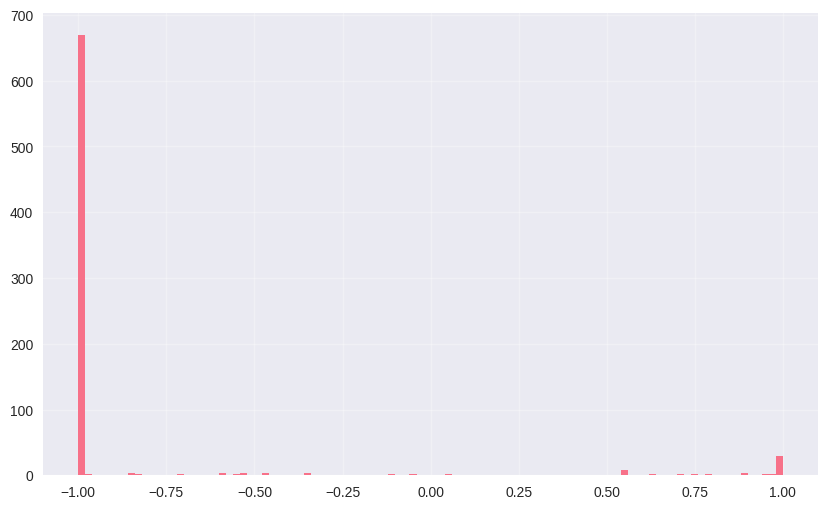

In [18]:
for sample in valid_dataset:
    img, label = sample
    print(type(img), img.shape)
    print(type(label), label.shape)
    print(img.flatten().shape)
    plt.hist(img.flatten(), bins=100)
    break

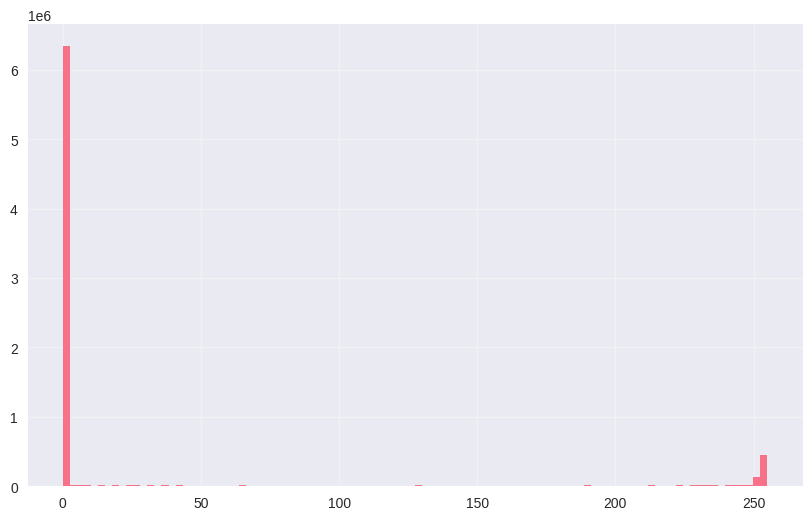

In [19]:
plt.hist(valid_dataset.data.numpy().flatten(), bins=100);

In [20]:
NOISE_RATE = 0.1
DATA_RANGE = (-1, 1)

# customized collation function
collate_fn = partial(collate_ae_dataset, noise_rate=NOISE_RATE, data_range=DATA_RANGE)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, drop_last=True)

In [21]:
valid_loader

Batch idx: 0
Noisy imgs: 	type: <class 'torch.Tensor'> 	len: 128 	shape: torch.Size([128, 1, 28, 28])
Imgs: 		type: <class 'torch.Tensor'> 	len: 128 	shape: torch.Size([128, 1, 28, 28])
Labels: 	type: <class 'torch.Tensor'> 	len: 128 	shape: torch.Size([128])


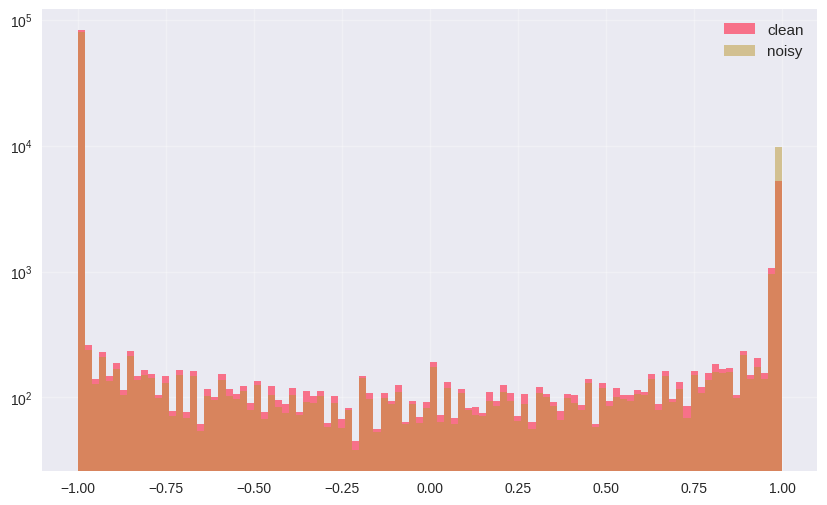

In [22]:
# Iteration on the dataloader
for batch_idx, (noisy_imgs, imgs, labels) in enumerate(valid_loader):
    print("Batch idx:", batch_idx)
    print("Noisy imgs:", "\ttype:", type(noisy_imgs), "\tlen:", len(noisy_imgs), "\tshape:", noisy_imgs.shape)
    print("Imgs:", "\t\ttype:", type(imgs), "\tlen:", len(imgs), "\tshape:", imgs.shape)
    print("Labels:", "\ttype:", type(labels), "\tlen:", len(labels), "\tshape:", labels.shape)
    plt.hist(imgs.flatten().cpu().numpy(), bins=100);
    plt.hist(noisy_imgs.flatten().cpu().numpy(), bins=100, alpha=0.5);
    plt.yscale('log')
    plt.legend(['clean', 'noisy'])
    break
    #what we did was first standardize the data, then we got rid of the noise and then you can put in noise before you train the model

In [23]:
for s in train_loader:
  xns, xs, ys = s
  print(xns.shape, xs.shape, ys.shape)
  break

torch.Size([128, 1, 28, 28]) torch.Size([128, 1, 28, 28]) torch.Size([128])


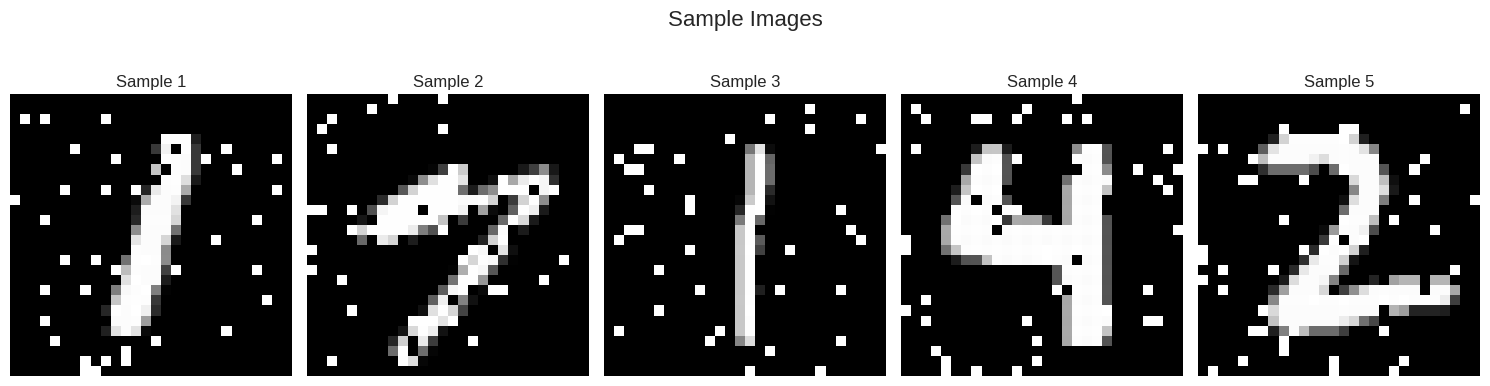

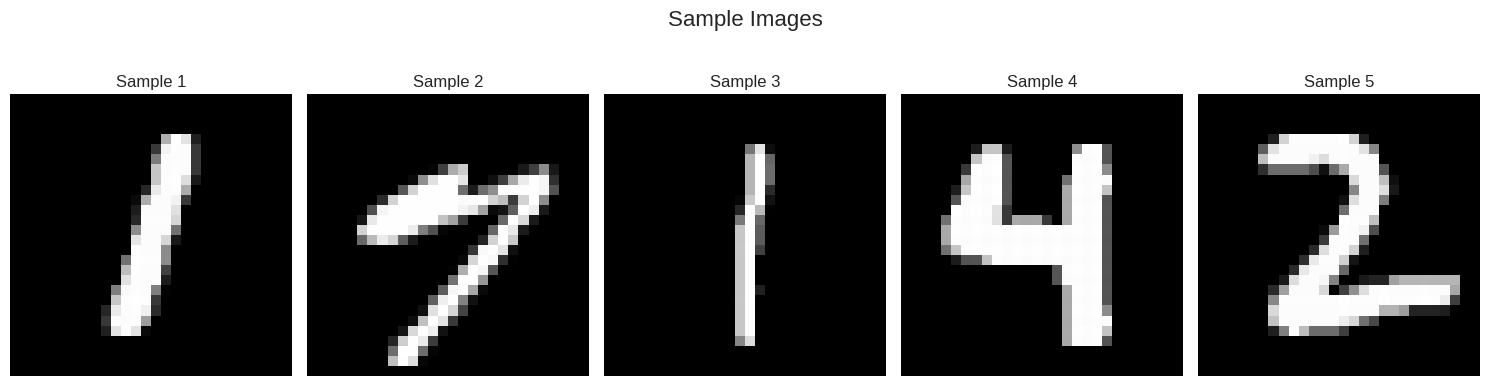

In [24]:
plot_im_samples(xns, is_torch=True)
plot_im_samples(xs, is_torch=True)
#here you can see the difference between noise and no noise

In [25]:
# fill array of all preprocessed training samples, converted to numpy:
train_images = []
for batch_idx, (noisy_data, data, target) in enumerate(train_loader):
    train_images.append(data.detach().cpu().numpy())

train_images = np.concatenate(train_images, axis=0)

In [26]:
print ("train_images.shape = ", train_images.shape)
print ("train_images.dtype = ", train_images.dtype)
print ("train_images.mean/std() = ", get_mean_std(train_images))
print ("train_images.min/max() = ", get_min_max(train_images))

train_images.shape =  (59904, 1, 28, 28)
train_images.dtype =  float32
train_images.mean/std() =  (np.float32(-0.73869985), np.float32(0.6161949))
train_images.min/max() =  (np.float32(-1.0), np.float32(1.0))


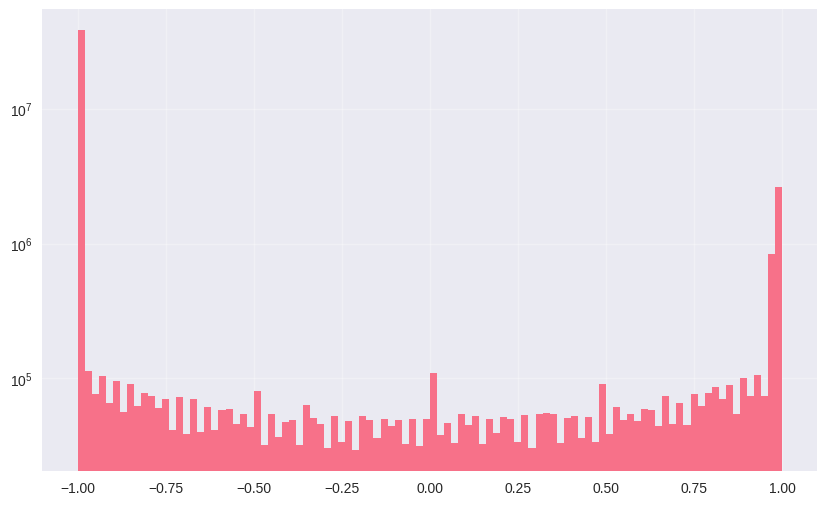

In [27]:
plt.hist(train_images.flatten(), bins=100, log=True);

In [28]:
del train_images

We will also prepare a subsampled dataset from the validation set for the visualisation purpose.

In [29]:
def get_samples(valid_loader):
  # 1. get numpy array of all validation images:
  val_images_noisy = []
  val_images = []
  val_labels = []

  for batch_idx, (noisy_data, data, target) in enumerate(valid_loader):
      val_images_noisy.append(noisy_data.detach().cpu().numpy())
      val_images.append(data.detach().cpu().numpy())
      val_labels.append(target.detach().cpu().numpy())

  val_images_noisy = np.concatenate(val_images_noisy, axis=0)
  val_images = np.concatenate(val_images, axis=0)
  val_labels = np.concatenate(val_labels, axis=0)

  # 2. get numpy array of balanced validation samples for visualization:
  sample_images_noisy = []
  sample_images = []
  sample_labels = []
  single_el_idx = []  # indexes of single element per class for visualization

  n_class = np.max(val_labels) + 1
  for class_idx in range(n_class):
    map_c = val_labels == class_idx

    ims_c_noisy = val_images_noisy[map_c]
    ims_c = val_images[map_c]

    samples_idx = np.random.choice(len(ims_c), N_SAMPLE, replace=False)

    ims_c_noisy_samples = ims_c_noisy[samples_idx]
    ims_c_samples = ims_c[samples_idx]

    sample_images_noisy.append(ims_c_noisy_samples)
    sample_images.append(ims_c_samples)

    sample_labels.append([class_idx]*N_SAMPLE)

    start_idx = N_SAMPLE*class_idx
    single_el_idx.extend([start_idx + i for i in range(min(N_VIS_SAMPLE, N_SAMPLE))])

  sample_images_noisy = np.concatenate(sample_images_noisy, axis=0)
  sample_images = np.concatenate(sample_images, axis=0)
  sample_labels = np.concatenate(sample_labels, axis=0)
  single_el_idx = np.array(single_el_idx)

  samples = {
      'images_noisy': sample_images_noisy,
      'images': sample_images,
      'labels': sample_labels,
      'single_el_idx': single_el_idx

  }
  return samples

In [30]:
samples = get_samples(valid_loader)

In [31]:
samples['images'].shape, samples['labels'].shape

((320, 1, 28, 28), (320,))

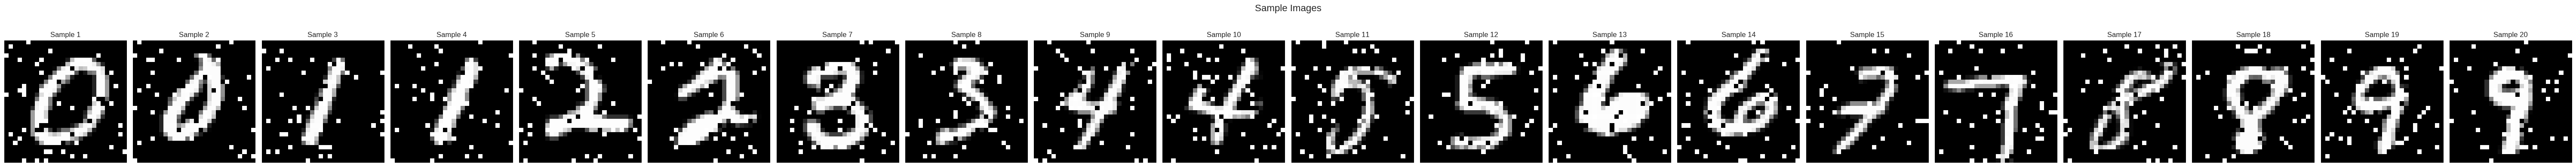

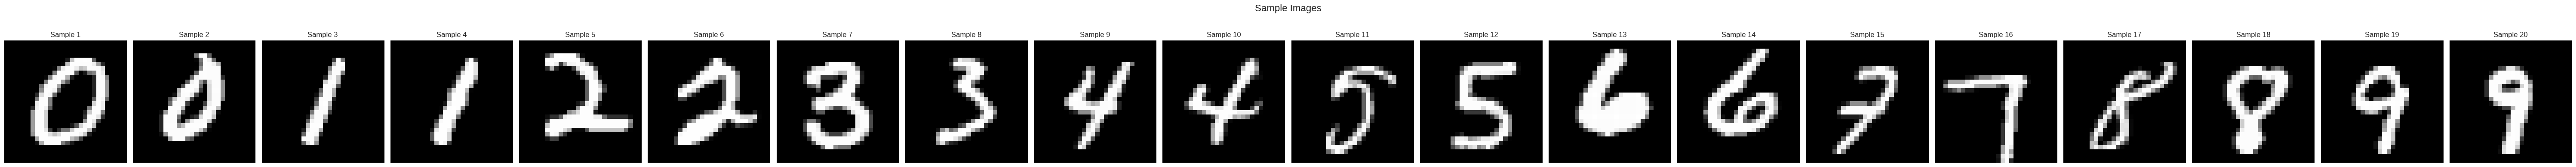

In [32]:
single_el_idx = samples['single_el_idx']
plot_im_samples(samples['images_noisy'][single_el_idx, 0], n=20, is_torch=False)
plot_im_samples(samples['images'][single_el_idx, 0], n=20, is_torch=False)

## Helper Autoencoder Interface

We will start from implementing an Autoencoder model base class

In [33]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size, code_size):
        self.input_size = list(input_size)  # shape of data sample
        self.flat_data_size = np.prod(self.input_size)
        self.hidden_size = 128

        self.code_size = code_size  # code size

        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(), # C x H x W = 1 x 28 x 28 = 784 vector

            nn.Linear(self.flat_data_size, self.hidden_size),
            nn.ReLU(),

            nn.Linear(self.hidden_size, self.code_size),
            nn.Sigmoid(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.code_size, self.hidden_size),
            nn.ReLU(),

            nn.Linear(self.hidden_size, self.flat_data_size),
            nn.Tanh(),  # Think: why tanh?

            nn.Unflatten(1, self.input_size),
        )

    def forward(self, x, return_z=False):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return (decoded, encoded) if return_z else decoded

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)*1.1

    def get_n_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


def eval_on_samples(ae_model, epoch, samples):
    # this is called on end of each training epoch
    xns = samples['images_noisy']
    xns = torch.tensor(xns, dtype=torch.float32).to(device)
    #labels = samples['labels']

    with torch.no_grad():
        yz = ae_model(xns, return_z=True)
        yz = [el.detach().cpu().numpy() for el in yz]

        y = yz[0]
        z = yz[1:]

    res = {'z': z, 'y': y, 'epoch': epoch}
    return res

In [34]:
# Training Visualization Functions

def plot_hist(history, logscale=True, figsize=(12, 6)):
    """
    Plot training history with enhanced styling
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    loss = history['loss']
    v_loss = history['val_loss']
    epochs = history['epoch']

    # Plot training curves
    plot_func = ax1.semilogy if logscale else ax1.plot

    line1 = plot_func(epochs, loss, label='Training Loss',
                     color=COLORS['encoder'], linewidth=3, alpha=0.8)
    line2 = plot_func(epochs, v_loss, label='Validation Loss',
                     color=COLORS['decoder'], linewidth=3, alpha=0.8)

    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training Progress', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # Add improvement metrics
    initial_train_loss = loss[0]
    final_train_loss = loss[-1]
    initial_val_loss = v_loss[0]
    final_val_loss = v_loss[-1]

    train_improvement = ((initial_train_loss - final_train_loss) / initial_train_loss) * 100
    val_improvement = ((initial_val_loss - final_val_loss) / initial_val_loss) * 100

    # Plot loss difference
    loss_diff = np.array(v_loss) - np.array(loss)
    ax2.plot(epochs, loss_diff, color=COLORS['latent'], linewidth=2)
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Validation - Training Loss', fontsize=12)
    ax2.set_title('Overfitting Monitor', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_samples(sample_history, samples, epoch_stride=5, fig_scale=1.5, max_epochs=None):
    """
    Enhanced visualization of sample reconstruction evolution
    """
    single_el_idx = samples['single_el_idx']
    images_noisy = samples['images_noisy'][single_el_idx, 0]
    images = samples['images'][single_el_idx, 0]

    epochs_to_show = sorted([ep for ep in sample_history.keys()
                           if ep % epoch_stride == 0 or ep == max(sample_history.keys())])

    if max_epochs:
        epochs_to_show = epochs_to_show[:max_epochs]

    for epoch_idx in epochs_to_show:
        hist_el = sample_history[epoch_idx]

        # Create three rows: noisy input, reconstruction, original
        samples_arr = [
            images_noisy,
            hist_el['y'][single_el_idx, 0],
            images
        ]

        row_labels = ['Noisy Input', 'Reconstruction', 'Ground Truth']

        # Create enhanced mosaic
        fig, ax = plt.subplots(figsize=(fig_scale * len(images_noisy), fig_scale * 3))

        mosaic_img = mosaic(samples_arr, spacing=2)
        im = ax.imshow(mosaic_img, cmap='gray', vmin=-0.5, vmax=0.5)

        # Add title and labels
        ax.set_title(f'Reconstruction Progress - Epoch {int(epoch_idx)}',
                    fontsize=16, fontweight='bold', pad=20)

        # Add row labels
        ax.set_ylabel(' | '.join(row_labels), fontsize=12, rotation=0, ha='right')
        ax.axis('off')

        # Add colorbar
        cbar = plt.colorbar(im, ax=ax, shrink=0.6, aspect=30)
        cbar.set_label('Pixel Value', fontsize=10)

        plt.tight_layout()
        plt.show()

def plot_latent_evolution(sample_history, samples, figsize=(15, 10)):
    """
    Visualize how latent space representations evolve during training
    """
    labels = samples['labels']
    epochs = sorted(sample_history.keys())

    # Select key epochs to show
    key_epochs = [epochs[0], epochs[len(epochs)//4], epochs[len(epochs)//2],
                  epochs[3*len(epochs)//4], epochs[-1]]

    fig, axes = plt.subplots(1, len(key_epochs), figsize=figsize)
    fig.suptitle('Latent Space Evolution', fontsize=18, fontweight='bold')

    for i, epoch in enumerate(key_epochs):
        z = sample_history[epoch]['z'][0]  # Get latent representations

        scatter = axes[i].scatter(z[:, 0], z[:, 1], c=labels,
                                cmap='tab10', s=30, alpha=0.7)
        axes[i].set_title(f'Epoch {epoch}', fontsize=14)
        axes[i].set_xlabel('Latent Dim 1', fontsize=10)
        axes[i].set_ylabel('Latent Dim 2', fontsize=10)
        axes[i].grid(True, alpha=0.3)

        # Set consistent axis limits
        axes[i].set_xlim(-6, 6)
        axes[i].set_ylim(-6, 6)

    # Add colorbar for digit labels
    cbar = plt.colorbar(scatter, ax=axes[-1], shrink=0.8)
    cbar.set_label('Digit Class', fontsize=12)

    plt.tight_layout()
    plt.show()

In [35]:
def run_on_trained(model, root_dir, run_fn, device, ep=None, model_filename=None):
    """
    Helper function to excecute any function on model in state after `ep` training epoch
    """

    if model_filename is None:
        if ep is not None:
            model_filename = root_dir/f'model_{ep:03d}.pth'
        else:
            model_filename = sorted(list(root_dir.glob('*.pth')))[-1]  # last model state
    if device == torch.device('cpu'):
        model_dict = torch.load(model_filename, map_location='cpu', weights_only=False)
    else:
        model_dict = torch.load(model_filename, weights_only=False)

    model.load_state_dict(model_dict['model_state_dict'])

    run_fn(model)

def run_on_all_training_history(model, root_dir, run_fn, device, n_ep=None):
    """
    Helper function to excecute any function on model state after each of the training epochs
    """
    if n_ep is not None:
        for ep in range(n_ep):
            print(f'running on epoch {ep+1}/{n_ep}...')
            run_on_trained(model, root_dir, run_fn, device, ep=ep)
    else:
        for model_filename in sorted(root_dir.glob('*.pth')):
            print(f'running on checkpoint {model_filename}...')
            run_on_trained(model, root_dir, run_fn, device, model_filename=model_filename)
    print(f'done')

sample shapes: torch.Size([128, 1, 28, 28]) torch.Size([128, 1, 28, 28]) torch.Size([128])
output shape: torch.Size([128, 1, 28, 28])


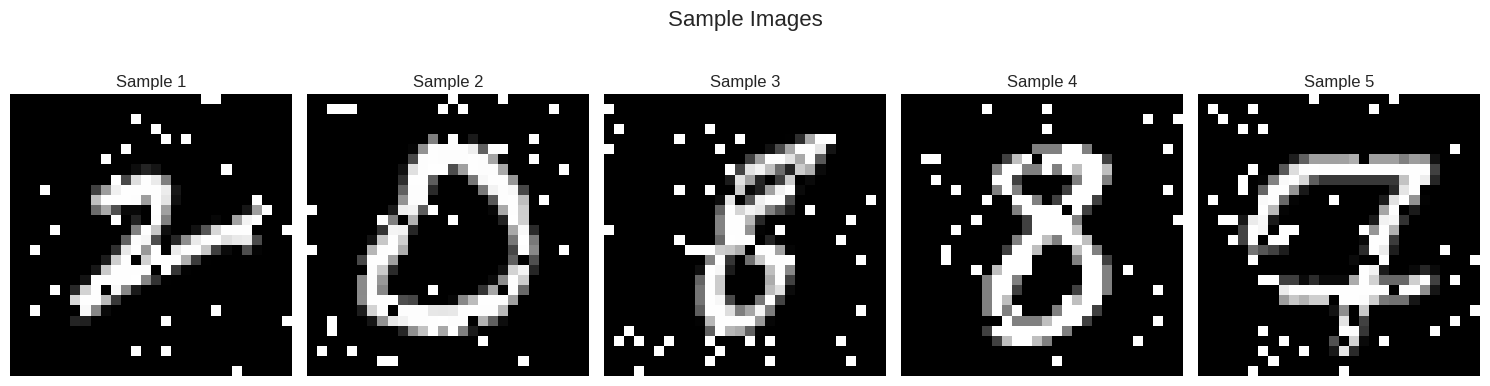

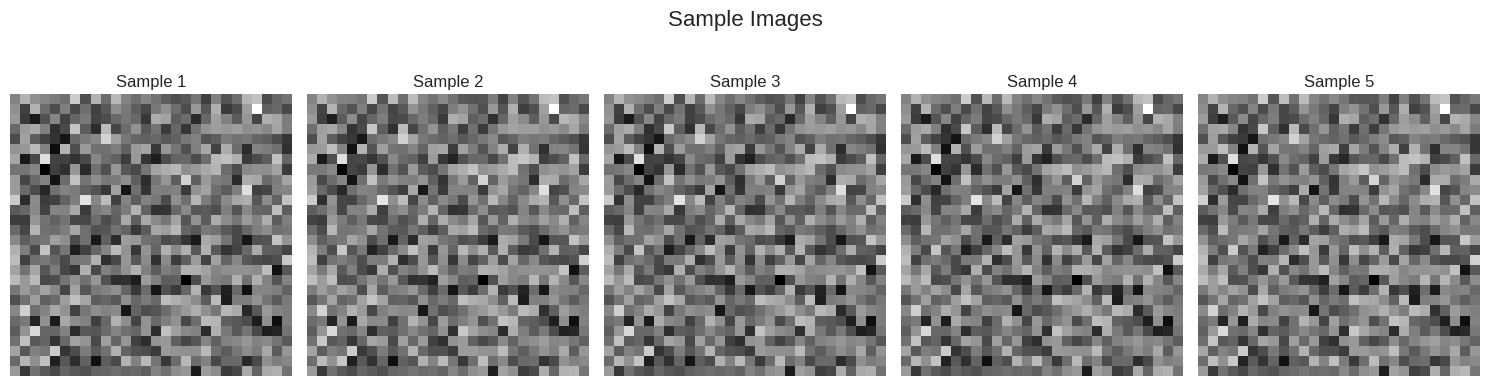

In [36]:
train_batch = next(iter(train_loader))
xns, xs, ys = train_batch
print('sample shapes:', xns.shape, xs.shape, ys.shape)
in_size = xns.shape[1:]

ae = AutoEncoder(input_size=in_size, code_size=5).to(device)
y = ae(xns)
print('output shape:', y.shape)
plot_im_samples(xns, is_torch=True)
plot_im_samples(y, is_torch=True)

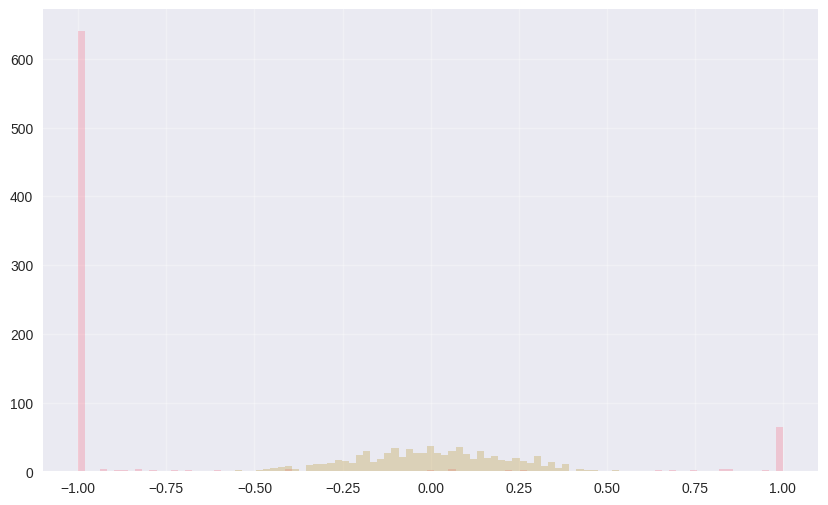

In [37]:
x = xns[0]# - y[1]
d = y[0]# - y[1]

im0 = x[0].detach().cpu().numpy()
im1 = d[0].detach().cpu().numpy()

# plt.imshow(im, cmap='gray', vmin=-1, vmax=1)
bins = np.linspace(-1, 1, 100)
plt.hist(im0.flatten(), bins, alpha=0.3);
plt.hist(im1.flatten(), bins, alpha=0.3);

In [38]:
ae.get_n_params()

203029

Autoencoder Architecture Visualization:


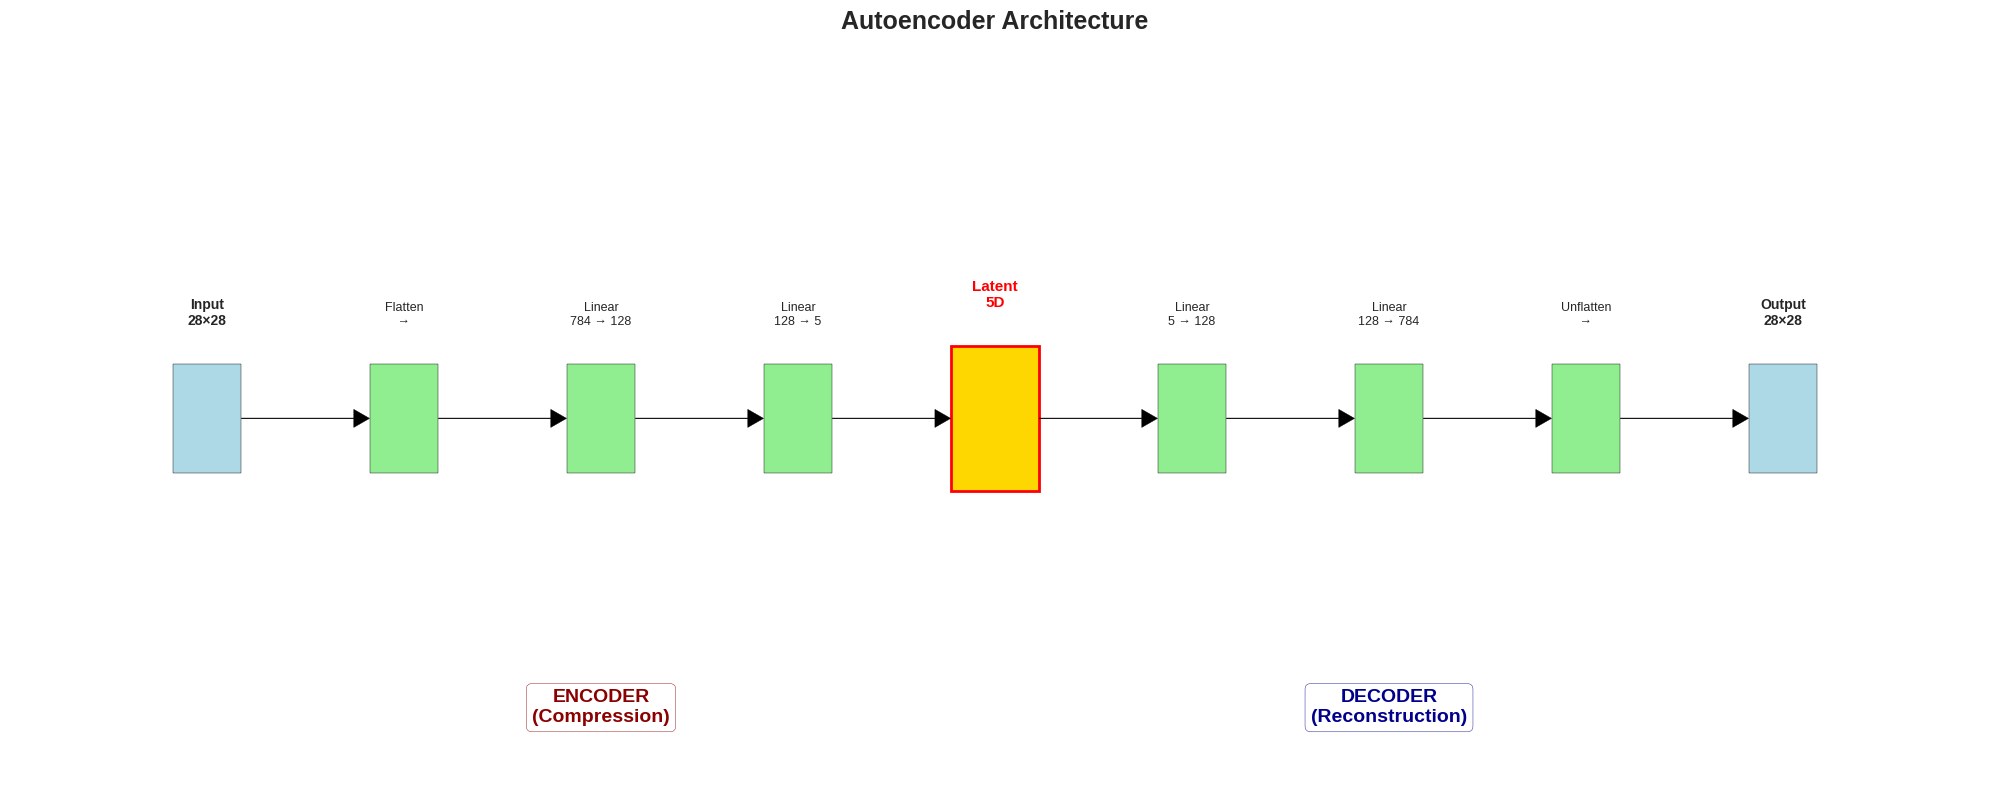

In [39]:
# Understanding the Architecture

# Visualize the autoencoder architecture
print("Autoencoder Architecture Visualization:")
visualize_autoencoder_architecture(ae, in_size)

# Simple Autoencoder

<div>

<h3> Architecture Overview</h3>

Our first autoencoder follows a simple **Encoder-Decoder** architecture:

**Encoder Path (Dimensionality Reduction):**
- Input: 28×28 = 784 pixels
- Hidden Layer: 128 neurons + ReLU
- **Bottleneck**: 5 neurons + Sigmoid (our latent space!)

**Decoder Path (Reconstruction):**
- Latent: 5 neurons
- Hidden Layer: 128 neurons + ReLU
- Output: 784 pixels + Tanh → reshape to 28×28

<div>
<strong>Key Questions to Consider:</strong>
<ul>
<li>Why do we use <code>Sigmoid</code> in the encoder bottleneck? What happens if we remove it?</li>
<li>Why <code>Tanh</code> in the decoder output?</li>
<li>What happens if we make the bottleneck even smaller (e.g., 2 neurons)?</li>
</ul>
</div>

</div>

## Experiment Setup

We'll train our autoencoder with **5 latent dimensions** on MNIST digits. Each image is 28x28 pixels. This means we're compressing 784-dimensional data into just 5 numbers. \
We start from image data since it's easy to interpret and judge the reconstruction quality visually, but the very same applies to other data types.

In [40]:
CODE_SIZE = 5
NOISE_RATE = 0
DATA_RANGE = (-1, 1)

MODEL_NAME = 'ae_model'
model = AutoEncoder(input_size=in_size, code_size=CODE_SIZE).to(device)

collate_fn = partial(collate_ae_dataset, noise_rate=NOISE_RATE, data_range=DATA_RANGE)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, drop_last=True)

samples = get_samples(valid_loader)

In [41]:
model

AutoEncoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=5, bias=True)
    (4): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Tanh()
    (4): Unflatten(dim=1, unflattened_size=[1, 28, 28])
  )
)

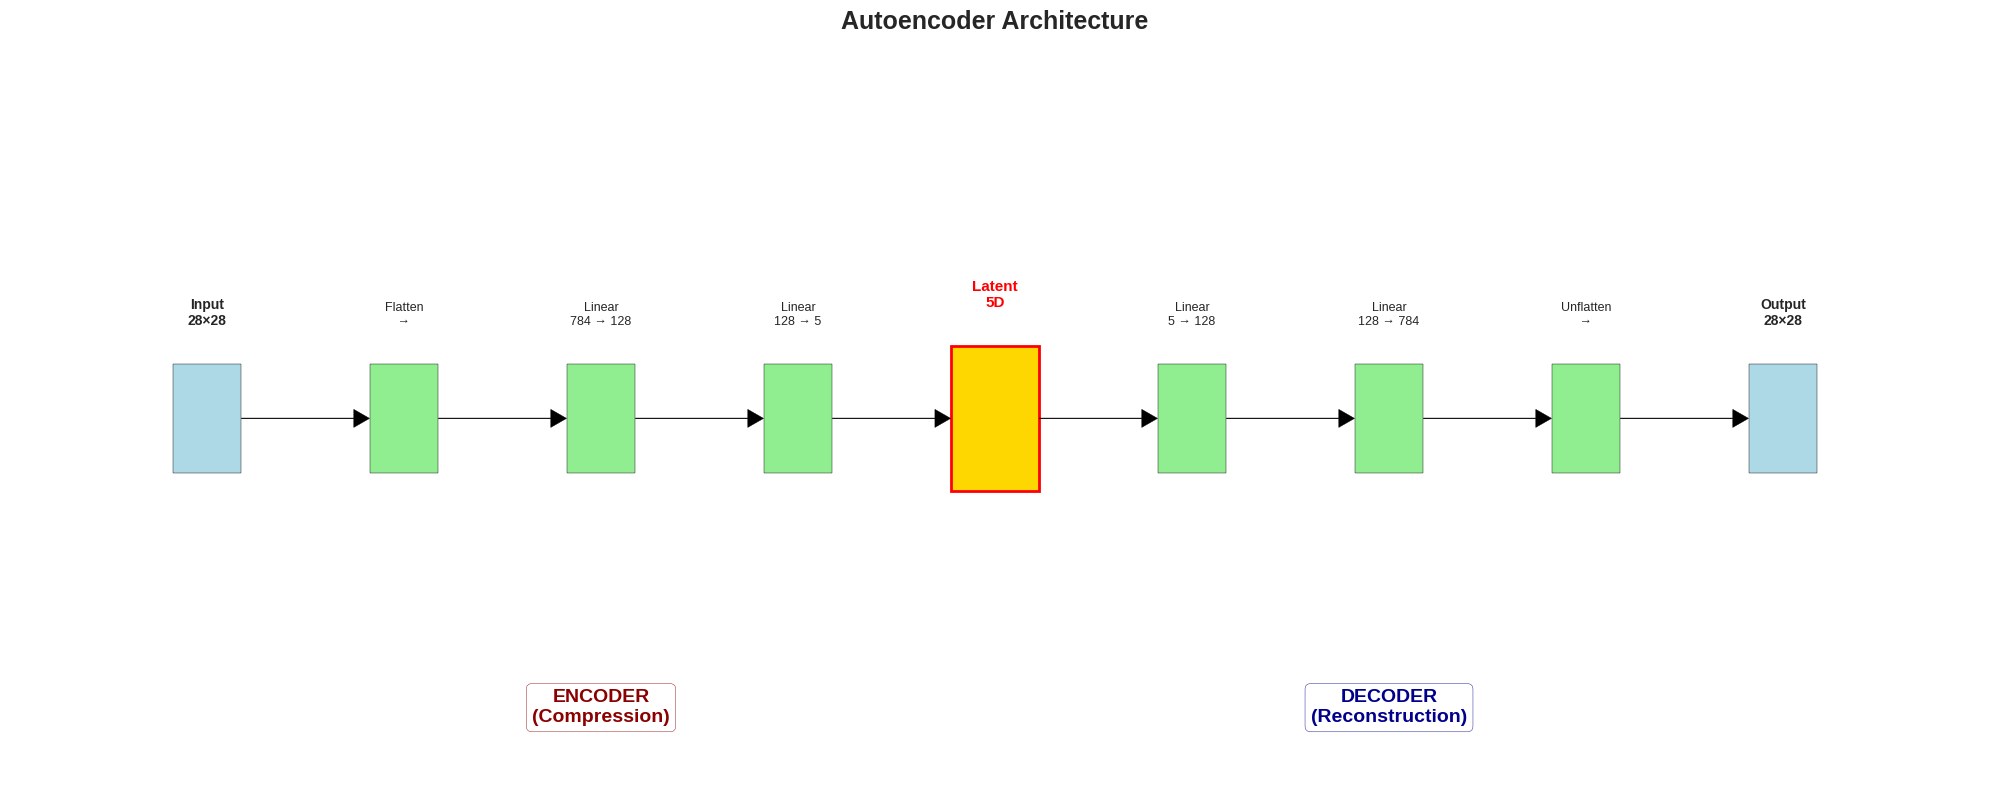

In [42]:
visualize_autoencoder_architecture(model, in_size)

In [43]:
# # Iteration on the dataloader
# for batch_idx, (noisy_imgs, imgs, labels) in enumerate(valid_loader):
#     print("Batch idx:", batch_idx)
#     # print("Noisy imgs:", "\ttype:", type(noisy_imgs), "\tlen:", len(noisy_imgs), "\tshape:", noisy_imgs.shape)
#     print("Imgs:", "\t\ttype:", type(imgs), "\tlen:", len(imgs), "\tshape:", imgs.shape)
#     print("Labels:", "\ttype:", type(labels), "\tlen:", len(labels), "\tshape:", labels.shape)
#     plt.hist(imgs.flatten().cpu().numpy(), bins=100, alpha=1);
#     plt.hist(noisy_imgs.flatten().cpu().numpy(), bins=100, alpha=0.5);
#     plt.yscale('log')
#     plt.legend(['clean', 'noisy'])
#     break

Train the model for 50 epochs

In [ ]:
# This will load a pre-trained model if available, otherwise start training

N_EPOCHS = 50
LR = 0.0009

model_root = pl.Path(MODEL_NAME)
model_root.mkdir(exist_ok=True)

optimizer = optim.Adam(model.parameters(), lr=LR)
loss = nn.MSELoss()

# Check for existing trained model
checkpoint_files = list(model_root.glob('model_*.pth'))
history = {'loss': [], 'val_loss': [], 'epoch': []}
sample_history = {}

if checkpoint_files:
    latest_checkpoint = max(checkpoint_files, key=lambda p: int(p.stem.split('_')[-1]))

    print(f"Loading existing model from: {latest_checkpoint}")
    if device == torch.device('cpu'):
        checkpoint = torch.load(latest_checkpoint, map_location=torch.device('cpu'), weights_only=False)
    else:
        checkpoint = torch.load(latest_checkpoint, weights_only=False)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1

    print(f"Loaded model trained for {checkpoint['epoch'] + 1} epochs")

    # Try to load training history if it exists
    history_file = model_root / 'training_history.pkl'
    sample_history_file = model_root / 'sample_history.pkl'

    if history_file.exists() and sample_history_file.exists():
        import pickle
        with open(history_file, 'rb') as f:
            history = pickle.load(f)
        with open(sample_history_file, 'rb') as f:
            sample_history = pickle.load(f)
        print(f"Loaded training history with {len(history['epoch'])} epochs")
    else:
        print("No training history found, will start fresh history tracking")
        start_epoch = 0  # Reset if no history available

    if start_epoch >= N_EPOCHS:
        print(f"Model already trained for {start_epoch} epochs (target: {N_EPOCHS})")
    else:
        print(f"Resuming training from epoch {start_epoch} to {N_EPOCHS}")

else:
    # start training from scratch
    print(f"No existing model found - starting training from scratch for {N_EPOCHS} epochs")
    start_epoch = 0

# Training loop
if start_epoch < N_EPOCHS:
    print(f"Starting training...")

    pbar = tqdm.tqdm(range(start_epoch, N_EPOCHS), postfix=f'epoch {start_epoch}/{N_EPOCHS}')
    for epoch_idx in pbar:
        epoch_loss = 0
        model.train()
        for batch_idx, (noisy_data, data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(noisy_data)
            loss_value = loss(output, data)
            loss_value.backward()
            optimizer.step()
            epoch_loss += loss_value.detach().cpu().item()
        epoch_loss /= len(train_loader)
        history['loss'].append(epoch_loss)
        history['epoch'].append(epoch_idx)

        # evaluate on validation set
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for batch_idx, (noisy_data, data, target) in enumerate(valid_loader):
                output = model(noisy_data)
                loss_value = loss(output, data)
                val_loss += loss_value.detach().cpu().item()
            val_loss /= len(valid_loader)
            history['val_loss'].append(val_loss)

        pbar.set_postfix({'epoch': f'{epoch_idx+1}/{N_EPOCHS}', 'loss':f'{epoch_loss:.4f}', 'val_loss':f'{val_loss:.4f}'})

        # evaluate on samples
        sample_res = eval_on_samples(model, epoch_idx, samples=samples)
        sample_history[epoch_idx] = sample_res

        # save model weights
        torch.save({
                    'epoch': epoch_idx,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss
                    }, model_root/f'model_{epoch_idx:03d}.pth')

    # Save training history and sample history after training completes
    print("Saving training history and sample history...")

    import pickle

    # Save training history
    history_file = model_root / 'training_history.pkl'
    with open(history_file, 'wb') as f:
        pickle.dump(history, f)

    # Save sample history
    sample_history_file = model_root / 'sample_history.pkl'
    with open(sample_history_file, 'wb') as f:
        pickle.dump(sample_history, f)

    print(f"Training history saved to: {history_file}")
    print(f"Sample history saved to: {sample_history_file}")
    print(f"Training completed - {len(history['epoch'])} epochs total")

else:
    print("Model already fully trained.")

No existing model found - starting training from scratch for 50 epochs
Starting training...


  0%|          | 0/50 [00:00<?, ?it/s, epoch 0/50]

Plot loss function evolution during training:

In [ ]:
plot_hist(history)

Let's visually compare network's output with the input

In [ ]:
plot_samples(sample_history, samples=samples, epoch_stride=10, fig_scale=1)

In [ ]:
sample_history[49]['z'][0].T.shape  # 320 samples (32 each class) x 5 elements

In [ ]:
for d in sample_history[49]['z'][0].T:
  plt.hist(d, 100, alpha=0.3);

In [ ]:
def compute_compression_metrics(model, samples, device):
    """
    Compute comprehensive compression metrics for the autoencoder

    Args:
        model: Trained autoencoder model
        samples: Dictionary containing validation samples
        device: PyTorch device (CPU/GPU)

    Returns:
        Dictionary with various compression metrics
    """
    model.eval()

    # Get sample data
    original_images = torch.tensor(samples['images']).to(device)
    labels = samples['labels']

    with torch.no_grad():
        # Get latent representations
        latent_codes = model.encode(original_images)
        reconstructions = model.decode(latent_codes)

    # Convert to numpy for analysis
    original_np = original_images.cpu().numpy()
    latent_np = latent_codes.cpu().numpy()
    reconstructed_np = reconstructions.cpu().numpy()

    # Dimensions
    original_shape = original_np.shape[1:]  # (1, 28, 28)
    latent_shape = latent_np.shape[1:]      # (code_size,)

    original_size = np.prod(original_shape)  # 784 pixels
    latent_size = np.prod(latent_shape)      # code_size

    # Basic compression ratio
    compression_ratio = original_size / latent_size
    compression_percentage = (1 - latent_size/original_size) * 100

    # Assuming 32-bit floats (4 bytes per value)
    bytes_per_value = 4

    original_bytes = original_size * bytes_per_value  # 784 * 4 = 3136 bytes
    latent_bytes = latent_size * bytes_per_value      # code_size * 4 bytes

    size_compression_ratio = original_bytes / latent_bytes
    size_reduction_percentage = (1 - latent_bytes/original_bytes) * 100

    # Entropy analysis (measure of information content)
    def compute_entropy(data, bins=256):
        """Compute entropy of data"""
        # Flatten and normalize to [0, 1]
        flat_data = data.flatten()
        normalized = (flat_data - flat_data.min()) / (flat_data.max() - flat_data.min() + 1e-8)

        # Create histogram
        hist, _ = np.histogram(normalized, bins=bins, density=True)
        hist = hist + 1e-12  # Avoid log(0)
        hist = hist / hist.sum()  # Normalize

        # Compute entropy
        entropy = -np.sum(hist * np.log2(hist))
        return entropy

    original_entropy = compute_entropy(original_np)
    latent_entropy = compute_entropy(latent_np)
    reconstructed_entropy = compute_entropy(reconstructed_np)

    # Information retention ratio
    info_retention = latent_entropy / original_entropy if original_entropy > 0 else 0

    # Latent space statistics
    latent_mean = np.mean(latent_np, axis=0)
    latent_std = np.std(latent_np, axis=0)
    latent_range = np.ptp(latent_np, axis=0)  # peak-to-peak (max - min)

    # Effective dimensionality (based on PCA)
    from sklearn.decomposition import PCA
    pca = PCA()
    pca.fit(latent_np)

    # 95% variance threshold
    cumvar = np.cumsum(pca.explained_variance_ratio_)
    effective_dims_95 = np.argmax(cumvar >= 0.95) + 1
    effective_dims_99 = np.argmax(cumvar >= 0.99) + 1

    metrics = {
        # Basic metrics
        'original_dimensions': original_shape,
        'latent_dimensions': latent_shape,
        'original_size': original_size,
        'latent_size': latent_size,

        # Compression ratios
        'compression_ratio': compression_ratio,
        'compression_percentage': compression_percentage,
        'size_compression_ratio': size_compression_ratio,
        'size_reduction_percentage': size_reduction_percentage,

        # Storage savings
        'original_bytes_per_image': original_bytes,
        'latent_bytes_per_image': latent_bytes,
        'bytes_saved_per_image': original_bytes - latent_bytes,

        # Information content
        'original_entropy': original_entropy,
        'latent_entropy': latent_entropy,
        'reconstructed_entropy': reconstructed_entropy,
        'information_retention_ratio': info_retention,

        # Latent space properties
        'latent_mean': latent_mean,
        'latent_std': latent_std,
        'latent_range': latent_range,
        'effective_dims_95': effective_dims_95,
        'effective_dims_99': effective_dims_99,
        'explained_variance_ratio': pca.explained_variance_ratio_,

        # Per-class analysis
        'labels': labels
    }

    return metrics

def print_compression_metrics(metrics):
    print(f"   Original Image Shape: {metrics['original_dimensions']}")
    print(f"   Latent Vector Shape:  {metrics['latent_dimensions']}")
    print(f"   Original Size:        {metrics['original_size']:,} values")
    print(f"   Latent Size:          {metrics['latent_size']:,} values")
    print()
    print(f"   Dimensional Compression:  {metrics['compression_ratio']:.1f}:1")
    print(f"   Space Reduction:          {metrics['compression_percentage']:.1f}%")
    print()
    print(f"   Original Size:        {metrics['original_bytes_per_image']:,} bytes per image")
    print(f"   Compressed Size:      {metrics['latent_bytes_per_image']:,} bytes per image")
    print(f"   For 10K images:       {metrics['bytes_saved_per_image']*10000/1024/1024:.1f} MB saved")

In [ ]:
metrics = compute_compression_metrics(model, samples, device)
print_compression_metrics(metrics)

# Denoising Autoencoder

<div>

<h3> The Denoising Challenge</h3>

**Regular Autoencoder Problem:** Can simply learn the identity function (especially with large latent space)

**Denoising Autoencoder Solution:**
- Add noise to input images
- Force the network to reconstruct the **clean** original
- This prevents trivial solutions and encourages robust representations

$$\text{Noisy Input} \xrightarrow{\text{Encoder}} \text{Latent} \xrightarrow{\text{Decoder}} \text{Clean Output}$$

<div>
<strong>Noise Strategy:</strong> We'll corrupt 20% of pixels with salt-and-pepper noise
<ul>
<li><strong>Salt:</strong> Random pixels set to +1 (white)</li>
<li><strong>Pepper:</strong> Random pixels set to -1 (black)</li>
<li><strong>Effect:</strong> Forces the network to "fill in" missing information</li>
</ul>
</div>

**Benefits:**
- More robust latent representations
- Better generalization
- Implicit regularization effect

</div>

In [ ]:
CODE_SIZE = 10
NOISE_RATE = 0.2
DATA_RANGE = (-1, 1)
MODEL_NAME = 'dae_model'
model = AutoEncoder(input_size=in_size, code_size=CODE_SIZE).to(device)

collate_fn = partial(collate_ae_dataset, noise_rate=NOISE_RATE, data_range=DATA_RANGE)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, drop_last=True)

samples = get_samples(valid_loader)

In [ ]:
model

In [ ]:
visualize_autoencoder_architecture(model, in_size)

Train the model for 50 epochs

In [ ]:
# train the autoencoder model, for N_EPOCHS epochs,
# save history of loss values for training and validation sets,
# history of validation samples evolution, and model weights history,

N_EPOCHS = 50
LR = 0.0009

model_root = pl.Path(MODEL_NAME)
model_root.mkdir(exist_ok=True)

optimizer = optim.Adam(model.parameters(), lr=LR)

# implement loss explicitly
loss = nn.MSELoss()

# train the model
history = {'loss': [], 'val_loss': [], 'epoch': []}
sample_history = {}

# Check for existing trained model
checkpoint_files = list(model_root.glob('model_*.pth'))
history = {'loss': [], 'val_loss': [], 'epoch': []}
sample_history = {}

if checkpoint_files:
    latest_checkpoint = max(checkpoint_files, key=lambda p: int(p.stem.split('_')[-1]))

    print(f"Loading existing model from: {latest_checkpoint}")
    if device == torch.device('cpu'):
        checkpoint = torch.load(latest_checkpoint, map_location=torch.device('cpu'), weights_only=False)
    else:
        checkpoint = torch.load(latest_checkpoint, weights_only=False)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1

    print(f"Loaded model trained for {checkpoint['epoch'] + 1} epochs")

    # Try to load training history if it exists
    history_file = model_root / 'training_history.pkl'
    sample_history_file = model_root / 'sample_history.pkl'

    if history_file.exists() and sample_history_file.exists():
        import pickle
        with open(history_file, 'rb') as f:
            history = pickle.load(f)
        with open(sample_history_file, 'rb') as f:
            sample_history = pickle.load(f)
        print(f"Loaded training history with {len(history['epoch'])} epochs")
    else:
        print("No training history found, will start fresh history tracking")
        start_epoch = 0  # Reset if no history available

    if start_epoch >= N_EPOCHS:
        print(f"Model already trained for {start_epoch} epochs (target: {N_EPOCHS})")
    else:
        print(f"Resuming training from epoch {start_epoch} to {N_EPOCHS}")

else:
    # start training from scratch
    print(f"No existing model found - starting training from scratch for {N_EPOCHS} epochs")
    start_epoch = 0

# Training loop
if start_epoch < N_EPOCHS:
    print(f"Starting training...")

    pbar = tqdm.tqdm(range(start_epoch, N_EPOCHS), postfix=f'epoch {start_epoch}/{N_EPOCHS}')
    for epoch_idx in pbar:
        epoch_loss = 0
        model.train()
        for batch_idx, (noisy_data, data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(noisy_data)
            loss_value = loss(output, data)
            loss_value.backward()
            optimizer.step()
            epoch_loss += loss_value.detach().cpu().item()
        epoch_loss /= len(train_loader)
        history['loss'].append(epoch_loss)
        history['epoch'].append(epoch_idx)

        # evaluate on validation set
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for batch_idx, (noisy_data, data, target) in enumerate(valid_loader):
                output = model(noisy_data)
                loss_value = loss(output, data)
                val_loss += loss_value.detach().cpu().item()
            val_loss /= len(valid_loader)
            history['val_loss'].append(val_loss)

        pbar.set_postfix({'epoch': f'{epoch_idx+1}/{N_EPOCHS}', 'loss':f'{epoch_loss:.4f}', 'val_loss':f'{val_loss:.4f}'})

        # evaluate on samples
        sample_res = eval_on_samples(model, epoch_idx, samples=samples)
        sample_history[epoch_idx] = sample_res

        # save model weights
        torch.save({
                    'epoch': epoch_idx,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss
                    }, model_root/f'model_{epoch_idx:03d}.pth')

    # Save training history and sample history after training completes
    print("Saving training history and sample history...")

    import pickle

    # Save training history
    history_file = model_root / 'training_history.pkl'
    with open(history_file, 'wb') as f:
        pickle.dump(history, f)

    # Save sample history
    sample_history_file = model_root / 'sample_history.pkl'
    with open(sample_history_file, 'wb') as f:
        pickle.dump(sample_history, f)

    print(f"Training history saved to: {history_file}")
    print(f"Sample history saved to: {sample_history_file}")
    print(f"Training completed - {len(history['epoch'])} epochs total")

else:
    print("Model already fully trained.")

Plot loss function evolution during training:

In [ ]:
plot_hist(history)

Visualise evolution of reconstruction:

In [ ]:
plot_samples(sample_history, samples=samples, epoch_stride=10, fig_scale=1)

# Exercises

<div>

## Exercise 1: Anomaly Detection with Autoencoders

<div>
<h4>Objective</h4>
Use the trained autoencoder to identify outliers in the validation dataset by analyzing reconstruction errors.
</div>

**Your Task:**

1. **Compute Reconstruction Errors**
   - Run the trained model on the entire validation dataset
   - Calculate loss for each sample
   - Store both the loss values and the corresponding images

2. **Analyze Error Distribution**
   - Plot histogram of reconstruction errors
   - Identify appropriate threshold for "high error" samples

3. **Visualize Anomalies**
   - Extract samples with highest reconstruction errors (top 1-5%)
   - Display these "poorly reconstructed" samples

</div>

<div>

### Advanced Challenge (Homework)

**UMAP Visualization of Latent Space**

1. **Extract Features**:
   - Get latent representations (z) for entire validation set
   - Also get raw pixel values (flattened)

3. **Create 2D Embeddings**:
   - Apply UMAP to both raw data and latent representations
   - Plot both embeddings side by side
   - Color points by digit class

4. **Highlight Outliers**:
   - Mark anomalous samples (high reconstruction error) in red
   - Compare their positions in both embedding spaces

Are anomalies clustered or scattered in the embeddings?

</div>

# Convolutional Autoencoder {#convolutional-autoencoder}

<div>

<h3> Why Convolutional Layers?</h3>

**Problems with Fully Connected Autoencoders:**
- Ignore spatial structure of images
- Too many parameters (784 → 128 = 100,352 weights!)
- Poor translation invariance

**Convolutional Autoencoder Advantages:**
- **Spatial Awareness:** Preserves local image structure
- **Parameter Sharing:** Dramatically fewer parameters
- **Translation Invariance:** Robust to object positions
- **Hierarchical Features:** Learns multi-scale representations

<div>
<h4>Architecture Design</h4>

**Encoder (Downsampling Path):**
```
Input: 1×28×28
Conv2d → 8×28×28 (features extraction)
Conv2d → 8×14×14 (stride=2, downsampling)  
Conv2d → 16×7×7 (stride=2, more features)
Conv2d → 16×4×4 (stride=2, further compression)
Conv2d → 32×2×2 (stride=2, final spatial compression)
Flatten + Linear → CODE_SIZE (final compression)
```

**Decoder (Upsampling Path):**
```
Linear → 32×2×2 (unflatten)
ConvTranspose2d → 16×4×4 (stride=2, upsample)
ConvTranspose2d → 16×7×7 (stride=2, upsample)
ConvTranspose2d → 8×14×14 (stride=2, upsample)
ConvTranspose2d → 8×28×28 (stride=2, upsample)
Conv2d → 1×28×28 (final reconstruction)
```
</div>

**Key Insight:** We can now use much smaller latent spaces (even 2D) while maintaining good reconstruction quality.

</div>

Instead of fully connected layers we can use strided convolutional layers in encoder, and transposed convolutions in decoder.
This model will have less parameters due to the weight sharing, thus easier to train.

After upscaling the image size will be a bit bigger then original, so we also crop reconstruction to the input image size.

In [ ]:
class ConvolutionalAutoEncoder(AutoEncoder):
    def __init__(self, input_size, code_size):
        self.input_size = list(input_size)  # shape of data sample

        self.hidden_size = 32*2*2

        self.code_size = code_size  # code size

        super(ConvolutionalAutoEncoder, self).__init__(input_size, code_size)
        self.encoder = nn.Sequential(
            nn.Conv2d(1,   8, 3, padding=1, stride=1), nn.LeakyReLU(negative_slope=0.3),
            nn.Conv2d(8,   8, 3, padding=1, stride=2), nn.LeakyReLU(negative_slope=0.3),
            nn.Conv2d(8,  16, 3, padding=1, stride=2), nn.LeakyReLU(negative_slope=0.3),
            nn.Conv2d(16, 16, 3, padding=1, stride=2), nn.LeakyReLU(negative_slope=0.3),
            nn.Conv2d(16, 32, 3, padding=1, stride=2), nn.LeakyReLU(negative_slope=0.3),

            nn.Flatten(),

            nn.Linear(self.hidden_size, self.hidden_size//8), nn.LeakyReLU(negative_slope=0.3),
            nn.Linear(self.hidden_size//8, self.code_size),
            # nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.code_size, self.hidden_size), nn.LeakyReLU(negative_slope=0.3),

            nn.Unflatten(1, (32, 2, 2)),

            nn.ConvTranspose2d(32, 16, 3, padding=1, output_padding=1, stride=2), nn.LeakyReLU(negative_slope=0.3),
            nn.ConvTranspose2d(16, 16, 3, padding=1, output_padding=1, stride=2), nn.LeakyReLU(negative_slope=0.3),
            nn.ConvTranspose2d(16,  8, 3, padding=1, output_padding=1, stride=2), nn.LeakyReLU(negative_slope=0.3),
            nn.ConvTranspose2d(8,   8, 3, padding=1, output_padding=1, stride=2), nn.LeakyReLU(negative_slope=0.3),
            nn.Conv2d(8, 1, 3, padding=1, stride=1), nn.Tanh(),
        )

    def decode(self, z):
        reconstruction = self.decoder(z)
        reconstruction = reconstruction[:, :, 2:-2, 2:-2]
        return reconstruction


Thus we can try to reduce sise of the latent space:

In [ ]:
CODE_SIZE = 2
NOISE_RATE = 0.2
MODEL_NAME = 'cdae_model'
model = ConvolutionalAutoEncoder(input_size=in_size, code_size=CODE_SIZE).to(device)

collate_fn = partial(collate_ae_dataset, noise_rate=NOISE_RATE, data_range=DATA_RANGE)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, drop_last=True)

samples = get_samples(valid_loader)

In [ ]:
xns = torch.tensor(samples['images_noisy']).to(device)
print(xns.shape)
zs = model.encode(xns)
ys = model(xns)
print(zs.shape)
print(ys.shape)

In [ ]:
model

In [ ]:
model.get_n_params()

In [ ]:
visualize_autoencoder_architecture(model, in_size)

Train the model for 70 epochs

In [ ]:
# train the autoencoder model, for N_EPOCHS epochs,
# save history of loss values for training and validation sets,
# history of validation samples evolution, and model weights history,

N_EPOCHS = 70
LR = 0.0004

model_root = pl.Path(MODEL_NAME)
model_root.mkdir(exist_ok=True)

optimizer = optim.Adam(model.parameters(), lr=LR)

# implement loss explicitly
loss = nn.L1Loss()

# Check for existing trained model
checkpoint_files = list(model_root.glob('model_*.pth'))
history = {'loss': [], 'val_loss': [], 'epoch': []}
sample_history = {}

if checkpoint_files:
    latest_checkpoint = max(checkpoint_files, key=lambda p: int(p.stem.split('_')[-1]))

    print(f"Loading existing model from: {latest_checkpoint}")
    if device == torch.device('cpu'):
        checkpoint = torch.load(latest_checkpoint, map_location=torch.device('cpu'), weights_only=False)
    else:
        checkpoint = torch.load(latest_checkpoint, weights_only=False)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1

    print(f"Loaded model trained for {checkpoint['epoch'] + 1} epochs")

    # Try to load training history if it exists
    history_file = model_root / 'training_history.pkl'
    sample_history_file = model_root / 'sample_history.pkl'

    if history_file.exists() and sample_history_file.exists():
        import pickle
        with open(history_file, 'rb') as f:
            history = pickle.load(f)
        with open(sample_history_file, 'rb') as f:
            sample_history = pickle.load(f)
        print(f"Loaded training history with {len(history['epoch'])} epochs")
    else:
        print("No training history found, will start fresh history tracking")
        start_epoch = 0  # Reset if no history available

    if start_epoch >= N_EPOCHS:
        print(f"Model already trained for {start_epoch} epochs (target: {N_EPOCHS})")
    else:
        print(f"Resuming training from epoch {start_epoch} to {N_EPOCHS}")

else:
    # start training from scratch
    print(f"No existing model found - starting training from scratch for {N_EPOCHS} epochs")
    start_epoch = 0

# Training loop
if start_epoch < N_EPOCHS:
    print(f"Starting training...")

    pbar = tqdm.tqdm(range(start_epoch, N_EPOCHS), postfix=f'epoch {start_epoch}/{N_EPOCHS}')
    for epoch_idx in pbar:
        epoch_loss = 0
        model.train()
        for batch_idx, (noisy_data, data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(noisy_data)
            loss_value = loss(output, data)
            loss_value.backward()
            optimizer.step()
            epoch_loss += loss_value.detach().cpu().item()
        epoch_loss /= len(train_loader)
        history['loss'].append(epoch_loss)
        history['epoch'].append(epoch_idx)

        # evaluate on validation set
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for batch_idx, (noisy_data, data, target) in enumerate(valid_loader):
                output = model(noisy_data)
                loss_value = loss(output, data)
                val_loss += loss_value.detach().cpu().item()
            val_loss /= len(valid_loader)
            history['val_loss'].append(val_loss)

        pbar.set_postfix({'epoch': f'{epoch_idx+1}/{N_EPOCHS}', 'loss':f'{epoch_loss:.4f}', 'val_loss':f'{val_loss:.4f}'})

        # evaluate on samples
        sample_res = eval_on_samples(model, epoch_idx, samples=samples)
        sample_history[epoch_idx] = sample_res

        # save model weights
        torch.save({
                    'epoch': epoch_idx,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss
                    }, model_root/f'model_{epoch_idx:03d}.pth')

    # Save training history and sample history after training completes
    print("Saving training history and sample history...")

    import pickle

    # Save training history
    history_file = model_root / 'training_history.pkl'
    with open(history_file, 'wb') as f:
        pickle.dump(history, f)

    # Save sample history
    sample_history_file = model_root / 'sample_history.pkl'
    with open(sample_history_file, 'wb') as f:
        pickle.dump(sample_history, f)

    print(f"Training history saved to: {history_file}")
    print(f"Sample history saved to: {sample_history_file}")
    print(f"Training completed - {len(history['epoch'])} epochs total")

else:
    print("Model already fully trained.")

Plot loss function evolution during training:

In [ ]:
plot_hist(history)

Visualise evolution of reconstruction:

In [ ]:
plt.hist(samples['images'].flatten(), bins=100, log=True);
plt.show()
plt.close()
for k in ['y', 'z']:
    # print(sample_history[0]['y'].shape)
    plt.hist(np.array(sample_history[0][k]).flatten(), bins=100, log=True);
    plt.hist(np.array(sample_history[N_EPOCHS-1][k]).flatten(), bins=100, log=True, alpha=0.3);
    plt.legend(['first epoch', 'last epoch'])
    plt.show()
    plt.close()

In [ ]:
plot_samples(sample_history, samples=samples, epoch_stride=10, fig_scale=1)

In [ ]:
print("Reconstruction Quality Analysis:")
visualize_reconstruction_quality_analysis(model, samples, device)

## Latent space

So far we looked just on the output: the model sort of does the job. But what does it learn?

First let's use animation to visualize reconstruction evolution:

In [ ]:
%%capture

single_el_idx = samples['single_el_idx']
images_noisy = samples['images_noisy'][single_el_idx, 0]
images = samples['images'][single_el_idx, 0]

smpl_ims = []
for epoch_idx, hist_el in sample_history.items():
    samples_arr = [images_noisy, hist_el['y'][single_el_idx, 0], images]
    smpl_ims.append(samples_arr)

ny, nx = len(smpl_ims[0]), len(smpl_ims[0][0])

plt.rcParams["animation.html"] = "jshtml"  # for matplotlib 2.1 and above animations use JavaScript

s=1
fig = plt.figure(figsize=(s*nx, s*ny))

m = mosaic(smpl_ims[0])

ttl = plt.title(f'after epoch {int(0)}')
# plot 0th epoch - 0th frame
imsh = plt.imshow(m, cmap='gray', vmin=-0.5, vmax=0.5)

# this function will be called to render each of the frames
def animate(i):
    m = mosaic(smpl_ims[i])
    imsh.set_data(m)

    ttl.set_text(f'after epoch {i}')

    return imsh

# create animation
ani = animation.FuncAnimation(fig, animate, frames=len(smpl_ims))

In [ ]:
# display animation
ani

And let's see evolution of the latent representations:

In [ ]:
%%capture
plt.rcParams["animation.html"] = "jshtml"  # for matplotlib 2.1 and above, uses JavaScript
fig = plt.figure(figsize=(8,8))

labels = samples['labels']
epochs = sorted(sample_history.keys())
z_res = [sample_history[ep]['z'][0] for ep in epochs]


scat = plt.scatter(z_res[0][:,0], z_res[0][:,1], c=labels, cmap=cm.rainbow)
plt.xlim(-6.1, 6.1)
plt.ylim(-6.1, 6.1)

ax = plt.gca()
legend1 = ax.legend(*scat.legend_elements(), title="digits")
ax.add_artist(legend1)
ax.set_aspect('equal')
ttl = plt.title(f'after epoch {0}')

def animate(i):
    z = z_res[i]
    scat.set_offsets(z)
    ttl.set_text(f'after epoch {i}')
    return scat

ani = animation.FuncAnimation(fig, animate, frames=len(z_res))

In [ ]:
ani

## Sampling from latent space

But we can also use the trained model to generate samples based on the latent representation:

In [ ]:
z0 = np.random.uniform(size=(25, CODE_SIZE))*12-6  # get 20 random points in 2D sampled from uniform distribution between 0 and 1
z0_t = torch.tensor(z0, dtype=torch.float32).to(device)

ims_all = []

# this function will be called in saved model state after each training epoch
def fn(ae):
  with torch.no_grad():
    ims = ae.decode(z0_t)
    ims = ims.detach().cpu().numpy()
    ims_all.append(ims)

run_on_all_training_history(model, model_root, fn, device)

ims_all = np.array(ims_all)
print(ims_all.shape)
ims_all = ims_all[:, :, 0, :, :]  # remove channel dimension

In [ ]:
plt.hist(ims_all[0].flatten(), bins=100, log=True);
plt.hist(ims_all[-1].flatten(), bins=100, log=True, alpha=0.5);

In [ ]:
%%capture
fig = plt.figure(figsize=(20, 1.5))

m = mosaic([ims_all[0]])

imsh = plt.imshow(m, cmap='gray', vmin=0, vmax=1)
ttl = plt.title(f'after epoch {int(0)}')


def animate(i):
    m = mosaic([ims_all[i]])
    imsh.set_data(m)
    ttl.set_text(f'after epoch {i}')
    return imsh

ani = animation.FuncAnimation(fig, animate, frames=len(ims_all))

In [ ]:
ani

## Interpolation in latent space

In [ ]:
n_samples = 10
zs = np.meshgrid(np.linspace(-6, 6, n_samples),
                 np.linspace(-6, 6, n_samples))
zs = np.stack(zs, axis=-1).reshape(-1, 2)
zs_t = torch.tensor(zs, dtype=torch.float32).to(device)

In [ ]:
# Advanced Latent Space Exploration & Analysis

print("Interactive Latent Space Grid Exploration:")
print("This shows what the decoder generates at different points in latent space")
visualize_latent_interpolation_grid(model, device, latent_dim=CODE_SIZE, n_steps=8, range_vals=(-4, 4))

print("Digit-to-Digit Interpolation:")
print("Watch how one digit morphs into another by interpolating in latent space")
visualize_digit_interpolation(model, samples, device, digit1=3, digit2=8, n_steps=10)
visualize_digit_interpolation(model, samples, device, digit1=1, digit2=7, n_steps=10)

## Interactive Latent Space Explorer

<div>
<h3>Hands-on Exploration</h3>
<p style="margin: 0;">Use the interactive widgets below to explore what your trained autoencoder has learned!</p>
</div>

In [ ]:
# Interactive Latent Space Explorer
# Note: This will only work if you have a trained model with at least 2 latent dimensions

try:
    if CODE_SIZE >= 2:
        explorer = create_interactive_latent_explorer(model, samples, device)
        display(explorer)
    else:
        print("Interactive explorer requires at least 2 latent dimensions!")
        print(f"Current model has {CODE_SIZE} dimensions.")
except NameError:
    print("Please train a convolutional autoencoder first!")
except Exception as e:
    print(f"Interactive widgets not available: {e}")
    print("You can still explore latent space using the grid sampling approach above!")

In [ ]:
# Interactive Noise Level Demo
# Explore how different noise levels affect the input images

try:
    noise_widget = create_noise_comparison_widget()
    display(noise_widget)
except Exception as e:
    print(f"Interactive widgets not available: {e}")
    print("You can still manually compare noise levels using the NOISE_RATE parameter!")

# Exercise 2: Hyperparameter Exploration

<div>

**Work in 2 groups**

<div>

### Option 1: Noise Robustness Study
How does noise level affect learned representations?

1. Train 4 autoencoders with noise rates: `[0.0, 0.2, 0.6, 0.8]`
2. Keep all other hyperparameters constant (architecture, epochs, learning rate)
3. For each model, analyze:
   - **Reconstruction Quality**: Visual comparison + MSE
   - **Latent Space Structure**: 2D scatter plots colored by digit
   - **Training Dynamics**: Loss curves comparison

</div>

<div>

### Option 2: Latent Dimensionality Study  
How does bottleneck size affect compression vs. quality trade-off?

1. Train 5 autoencoders with latent sizes: `[2, 4, 8, 16, 32]`
2. Use fixed noise rate (e.g., 0.2) and other hyperparameters
3. For each model, analyze:
   - **Compression Ratio**: Input size / Latent size
   - **Reconstruction Quality**: Visual comparison + MSE
   - **Parameter Count**: Model size comparison

</div>

## Exercise 3: Writing latent Dataset


In this exercise, we will
1. modify the CNN to be fully convolutional, with 4 downscaling layers (x16), 16 channels
2. save dataset of latent states, see code below for example.

In [ ]:
import pickle

def save_pckl(obj, fname):
    with open(fname, 'wb') as f:
        pickle.dump(obj, f, pickle.DEFAULT_PROTOCOL)

def load_pckl(fname):
    with open(fname, 'rb') as f:
        obj = pickle.load(f)
    return obj

In [ ]:
#load latest model checkpoint:
run_on_trained(model, model_root, lambda m:None, device, ep=3)

# dataset for latent DDM, file list:
data_files = {"train": [], "valid": []}

ds_root = pl.Path('data')
ds_root.mkdir(exist_ok=True)

# generate latent values per blocks of samples:
block_sz = 5000
for ds, sfx in zip([valid_dataset, train_dataset], ['valid', 'train']):
  x = ds.data.numpy().reshape(-1, 1, 28, 28)
  x = x/255.*2-1
  l = ds.targets.numpy()

  for i in range(0, len(x), block_sz):
    x_b = x[i:i+block_sz]
    l_b = l[i:i+block_sz]

    x_b_t = torch.tensor(x_b, dtype=torch.float32).to(device)

    with torch.no_grad():
        z_t = model.encode(x_b_t)
        z_b = z_t.detach().cpu().numpy()

    # save latent values and their shape and labels to a dataframe:
    data_d = {
    'z': [zi.flatten() for zi in z_b],
    'shape': [zi.shape for zi in z_b],
    'label': l_b
    }

    df = pd.DataFrame(data=data_d)

    # save dataframe to a file and reference dictioanry:
    fname = ds_root/f'df_z_{sfx}_{i}.pckl'
    save_pckl(df, fname)
    data_files[sfx].append(str(fname))

save_pckl(data_files, ds_root/'data_files.pkl')

In [ ]:
from datasets import load_dataset, Dataset

In [ ]:
# now we can load the dataset:
data_files = load_pckl(ds_root/'data_files.pkl')
lds = load_dataset('pandas', data_files=data_files)

In [ ]:
# convert to torch dataset:
tds = lds.with_format("torch")

In [ ]:
tds['train']['z'][0].shape, tds['train']['label'][0]

# Key Takeaways & Summary

<div style="padding: 25px; border-radius: 15px; margin: 20px 0;">

<h2 style="margin-top: 0;"> What We've Learned</h2>

<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 20px; margin-top: 20px;">

<div style="padding: 15px; border-radius: 10px;">
<h4 style="margin-top: 0;">Core Concepts</h4>
<ul style="margin: 0; padding-left: 20px;">
<li><strong>Encoder-Decoder Architecture</strong></li>
<li><strong>Latent Space Representations</strong></li>
<li><strong>Dimensionality Reduction</strong></li>
<li><strong>Reconstruction Loss</strong></li>
<li><strong>Regularization through Noise</strong></li>
</ul>
</div>

<div style="padding: 15px; border-radius: 10px;">
<h4 style="margin-top: 0;"> Practical Skills</h4>
<ul style="margin: 0; padding-left: 20px;">
<li><strong>PyTorch Implementation</strong></li>
<li><strong>Training Loop Design</strong></li>
<li><strong>Visualization Techniques</strong></li>
<li><strong>Hyperparameter Tuning</strong></li>
<li><strong>Model Evaluation</strong></li>
</ul>
</div>

</div>

</div>

<div style="margin: 20px 0;">

## Applications & Extensions

**Where can you use autoencoders?**

### **Creative Applications**
- **Style Transfer**: Learn artistic style representations
- **Image Colorization**: Convert grayscale to color images  
- **Super-Resolution**: Enhance image quality
- **Data Augmentation**: Generate training variations

### **Analysis & Detection**
- **Anomaly Detection**: Identify unusual patterns in data
- **Fraud Detection**: Spot irregular financial transactions
- **Medical Imaging**: Detect abnormalities in scans
- **Quality Control**: Find defects in manufacturing

### **Advanced Architectures**
- **Variational Autoencoders (VAEs)**: Probabilistic latent spaces
- **Beta-VAEs**: Disentangled representations
- **Adversarial Autoencoders**: GAN-like training
- **Transformer Autoencoders**: For sequential data

</div>

<div style="padding: 20px; border-radius: 15px; border-left:margin: 20px 0;">

## Design Principles We've Discovered

<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 20px;">

<div>
<h4> Architecture Choices</h4>
<ul>
<li><strong>Bottleneck Size</strong>: Balance compression vs. quality</li>
<li><strong>Layer Depths</strong>: Deeper = more complex features</li>
<li><strong>Activation Functions</strong>: Sigmoid/Tanh for bounded outputs</li>
<li><strong>Convolutional Layers</strong>: Preserve spatial relationships</li>
</ul>
</div>

<div>
<h4>Training Strategies</h4>
<ul>
<li><strong>Noise Injection</strong>: Prevents overfitting, improves robustness</li>
<li><strong>Learning Rate</strong>: Start high, decay over time</li>
<li><strong>Batch Size</strong>: Balance memory and gradient stability</li>
<li><strong>Regularization</strong>: Dropout, weight decay, early stopping</li>
</ul>
</div>

</div>

</div>

<div style="padding: 20px; border-radius: 15px; border-left: margin: 20px 0;">

## Common Pitfalls & Solutions

| Problem | Symptom | Solution |
|---------|---------|----------|
| **Identity Learning** | Perfect reconstruction, no compression | Add noise, reduce latent size |
| **Mode Collapse** | All outputs look similar | Increase latent size, better initialization |
| **Blurry Outputs** | Reconstructions lack sharp details | Use L1 loss, perceptual losses |
| **Overfitting** | Training loss << validation loss | More data, regularization, early stopping |

</div>

# VAE

While the previous model learn to seaparate subpopulations in the latent space, there remains significant overlap & unpopulated regions.

Varitional AE puts additional constraints on the distribution in the latent space and perform variational inference.

(see pptx for details)

Here the encoder will predict `2 x n_code` values: means and logarithm of variance for each sample. Since these values live in $R^2$ - no activation function is used in last layer of the encoder.

Then for reconstruction we will sample from this distribuition with a reparametrisation trick.

The tecnically complex part - is to implement the custom loss function and training loop.

In [ ]:
class VariationalConvolutionalAutoencoder(AutoEncoder):
    def __init__(self, input_size, code_size):
        super(VariationalConvolutionalAutoencoder, self).__init__(input_size, code_size)

        # nn.LeakyReLU(negative_slope=0.3)
        self.input_size = list(input_size)  # shape of data sample
        self.npix = np.prod(self.input_size)

        self.hidden_size = 64*1

        self.code_size = code_size  # code size

        self.encoder = nn.Sequential(
            nn.Conv2d(1,   16, 3, padding=1, stride=1), nn.LeakyReLU(negative_slope=0.3),
            nn.Conv2d(16,  16, 3, padding=1, stride=2), nn.LeakyReLU(negative_slope=0.3),
            nn.Conv2d(16,  32, 3, padding=1, stride=2), nn.LeakyReLU(negative_slope=0.3),
            nn.Conv2d(32,  32, 3, padding=1, stride=2), nn.LeakyReLU(negative_slope=0.3),
            nn.Conv2d(32,  32, 3, padding=1, stride=2), nn.LeakyReLU(negative_slope=0.3),
            nn.Conv2d(32,  64, 3, padding=1, stride=2), nn.LeakyReLU(negative_slope=0.3),

            nn.Flatten(),

            nn.Linear(self.hidden_size, 64), nn.LeakyReLU(negative_slope=0.3),

            # we want values in all R, thus no activation function is applied. self.n_code values for mean + self.n_code for log(variance)
            nn.Linear(64, self.code_size * 2),

        )
        self.decoder = nn.Sequential(
            nn.Linear(self.code_size, 64), nn.LeakyReLU(negative_slope=0.3),
            nn.Linear(64, self.hidden_size), nn.LeakyReLU(negative_slope=0.3),

            nn.Unflatten(1, (64, 1, 1)),

            nn.ConvTranspose2d(64, 32, 3, padding=1, output_padding=1, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 3, padding=1, output_padding=1, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 3, padding=1, output_padding=1, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, padding=1, output_padding=1, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(16, 16, 3, padding=1, output_padding=1, stride=2), nn.ReLU(),
            nn.Conv2d(16, 1, 3, padding=1, stride=1), nn.Tanh(),
        )

    def sample(self, eps=None):
        if eps is None:
            # samle from standard normal distribution
            eps = torch.randn((100, self.code_size))
        return self.decode(eps)

    def encode(self, x):
        z = self.encoder(x)
        z_mean, z_logvar = torch.split(z, split_size_or_sections=2, dim=1)
        return z_mean, z_logvar

    def reparameterize(self, z_mean, z_logvar):
        # reaparametrization trick: to sample z from N(mean, std):
        # z = mean + std * eps, where eps sampled from N(0, 1)
        eps = torch.randn_like(z_mean)
        z_std = torch.exp(z_logvar * .5)
        return eps * z_std + z_mean

    def decode(self, z):
        reconstruction = self.decoder(z)
        reconstruction = reconstruction[:, :, 2:-2, 2:-2]
        return reconstruction

    def forward(self, x, return_z=False):
        z_mean, z_logvar = self.encode(x)
        z = self.reparameterize(z_mean, z_logvar)
        reconstruction = self.decode(z)
        return (reconstruction, z_mean, z_logvar) if return_z else reconstruction

    def forward_and_KL_loss(self, x, y):
        reconstruction, z_mean, z_logvar = self(x, return_z=True)

        # tf impl:
        # loss_z_kl = 0.5 * tf.reduce_sum(tf.exp(z_logvar) + tf.square(z_mean) -1.0 - z_logvar, axis=1)  # KL divergence from N(0, 1) to N(z_mean, tf.exp(z_logvar * .5))
        # loss_z_kl = tf.reduce_mean(loss_z_kl) / np.prod(self.data_size)  # but since we used mean in reconstruction loss - this term has to be normalized accordingly

        # pytorch impl:
        loss_z_kl = 0.5 * torch.sum(torch.exp(z_logvar) + torch.square(z_mean) -1.0 - z_logvar, dim=1)
        loss_z_kl = torch.mean(loss_z_kl) / self.npix

        return reconstruction, loss_z_kl


In [ ]:
CODE_SIZE = 2 # 50
NOISE_RATE = 0.
DATA_RANGE = (-1, 1)
MODEL_NAME = 'vcae_model'
model = VariationalConvolutionalAutoencoder(input_size=in_size, code_size=CODE_SIZE).to(device)

collate_fn = partial(collate_ae_dataset, noise_rate=NOISE_RATE, data_range=DATA_RANGE)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, drop_last=True)
samples = get_samples(valid_loader)

In [ ]:
xns = torch.tensor(samples['images_noisy']).to(device)
print(xns.shape)
ys = model(xns)
ys.shape

In [ ]:
model

In [ ]:
model.get_n_params()

In [ ]:
# train the autoencoder model, for N_EPOCHS epochs,
# save history of loss values for training and validation sets,
# history of validation samples evolution, and model weights history,

N_EPOCHS = 20 # 20
LR = 0.0009

model_root = pl.Path(MODEL_NAME)
model_root.mkdir(exist_ok=True)

optimizer = optim.Adam(model.parameters(), lr=LR)
loss = nn.MSELoss()

# Check for existing trained model
checkpoint_files = list(model_root.glob('model_*.pth'))
history = {'loss': [], 'val_loss': [], 'rec_loss': [], 'rec_val_loss': [], 'kl_loss': [], 'kl_val_loss': [], 'epoch': []}
sample_history = {}

if checkpoint_files:
    latest_checkpoint = max(checkpoint_files, key=lambda p: int(p.stem.split('_')[-1]))

    print(f"Loading existing model from: {latest_checkpoint}")
    if device == torch.device('cpu'):
        checkpoint = torch.load(latest_checkpoint, map_location=torch.device('cpu'), weights_only=False)
    else:
        checkpoint = torch.load(latest_checkpoint, weights_only=False)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1

    print(f"Loaded model trained for {checkpoint['epoch'] + 1} epochs")

    # Try to load training history if it exists
    history_file = model_root / 'training_history.pkl'
    sample_history_file = model_root / 'sample_history.pkl'

    if history_file.exists() and sample_history_file.exists():
        import pickle
        with open(history_file, 'rb') as f:
            history = pickle.load(f)
        with open(sample_history_file, 'rb') as f:
            sample_history = pickle.load(f)
        print(f"Loaded training history with {len(history['epoch'])} epochs")
    else:
        print("No training history found, will start fresh history tracking")
        start_epoch = 0  # Reset if no history available

    if start_epoch >= N_EPOCHS:
        print(f"Model already trained for {start_epoch} epochs (target: {N_EPOCHS})")
    else:
        print(f"Resuming training from epoch {start_epoch} to {N_EPOCHS}")

else:
    # start training from scratch
    print(f"No existing model found - starting training from scratch for {N_EPOCHS} epochs")
    start_epoch = 0

# Training loop
if start_epoch < N_EPOCHS:
    print(f"Starting training...")
    pbar = tqdm.tqdm(range(N_EPOCHS), postfix=f'epoch 0/{N_EPOCHS}')
    for epoch_idx in pbar:
        epoch_loss = 0
        epoch_rec_loss = 0
        epoch_kl_loss = 0

        model.train()
        for batch_idx, (noisy_data, data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            #output = model(noisy_data)
            output, kl_loss = model.forward_and_KL_loss(noisy_data, data)
            rec_loss = loss(output, data)
            loss_value = rec_loss + kl_loss
            loss_value.backward()
            optimizer.step()

            epoch_loss += loss_value.detach().cpu().item()
            epoch_rec_loss += rec_loss.detach().cpu().item()
            epoch_kl_loss += kl_loss.detach().cpu().item()

        n_elements = len(train_loader)

        epoch_loss /= n_elements
        epoch_rec_loss /= n_elements
        epoch_kl_loss /= n_elements

        history['loss'].append(epoch_loss)
        history['rec_loss'].append(epoch_rec_loss)
        history['kl_loss'].append(epoch_kl_loss)

        history['epoch'].append(epoch_idx)
        # update progress bar

        # evaluate on validation set
        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_rec_loss = 0
            val_kl_loss = 0

            for batch_idx, (noisy_data, data, target) in enumerate(valid_loader):
                #output = model(noisy_data)
                output, kl_loss = model.forward_and_KL_loss(noisy_data, data)
                rec_loss = loss(output, data)
                loss_value = rec_loss + kl_loss

                val_loss += loss_value.detach().cpu().item()
                val_rec_loss += rec_loss.detach().cpu().item()
                val_kl_loss += kl_loss.detach().cpu().item()

            val_loss /= len(valid_loader)
            val_rec_loss /= len(valid_loader)
            val_kl_loss /= len(valid_loader)

            history['val_loss'].append(val_loss)
            history['rec_val_loss'].append(val_rec_loss)
            history['kl_val_loss'].append(val_kl_loss)

        pbar.set_postfix({'epoch': f'{epoch_idx+1}/{N_EPOCHS}', 'loss':f'{epoch_loss:.4f}', 'val_loss':f'{val_loss:.4f}'})
        # evaluate on samples
        sample_res = eval_on_samples(model, epoch_idx, samples=samples)
        sample_history[epoch_idx] = sample_res

        # save model weights
        torch.save({
                    'epoch': epoch_idx,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss
                    }, model_root/f'model_{epoch_idx:03d}.pth')

    # Save training history and sample history after training completes
    print("Saving training history and sample history...")

    import pickle

    # Save training history
    history_file = model_root / 'training_history.pkl'
    with open(history_file, 'wb') as f:
        pickle.dump(history, f)

    # Save sample history
    sample_history_file = model_root / 'sample_history.pkl'
    with open(sample_history_file, 'wb') as f:
        pickle.dump(sample_history, f)

    print(f"Training history saved to: {history_file}")
    print(f"Sample history saved to: {sample_history_file}")
    print(f"Training completed - {len(history['epoch'])} epochs total")

else:
    print("Model already fully trained.")

In [ ]:
model

In [ ]:
plot_hist(history)

In [ ]:
plot_samples(sample_history, samples=samples, epoch_stride=5, fig_scale=1)

Visualize reconstruciton:

In [ ]:
%%capture

single_el_idx = samples['single_el_idx']
images_noisy = samples['images_noisy'][single_el_idx, 0]
images = samples['images'][single_el_idx, 0]

smpl_ims = []
for epoch_idx, hist_el in sample_history.items():
    samples_arr = [images_noisy, hist_el['y'][single_el_idx, 0], images]
    smpl_ims.append(samples_arr)

ny, nx = len(smpl_ims[0]), len(smpl_ims[0][0])

plt.rcParams["animation.html"] = "jshtml"  # for matplotlib 2.1 and above animations use JavaScript

s=1
fig = plt.figure(figsize=(s*nx, s*ny))

m = mosaic(smpl_ims[0])

ttl = plt.title(f'after epoch {int(0)}')
# plot 0th epoch - 0th frame
imsh = plt.imshow(m, cmap='gray', vmin=0, vmax=1)

# this function will be called to render each of the frames
def animate(i):
    m = mosaic(smpl_ims[i])
    imsh.set_data(m)

    ttl.set_text(f'after epoch {i}')

    return imsh

# create animation
ani = animation.FuncAnimation(fig, animate, frames=len(smpl_ims))

In [ ]:
ani

Let's look at the latent representation:

In [ ]:
sample_history[0]['z'][0].shape

In [ ]:
%%capture
plt.rcParams["animation.html"] = "jshtml"  # for matplotlib 2.1 and above, uses JavaScript
fig = plt.figure(figsize=(8,8))

smpl_epochs = list(sample_history.keys())

z_res_mean = [sample_history[ep]['z'][0] for ep in smpl_epochs]
z_logvar = [sample_history[ep]['z'][1] for ep in smpl_epochs]
z_res_std = np.exp(np.array(z_logvar) * .5)


l_res = samples['labels']
l_col = [cm.rainbow(l_i/10) for l_i in l_res]

# error bars:
def get_lines(m, s):
  l = []
  for (x, y), (sx, sy) in zip(m, s):
    l.append([(x-sx, y), (x+sx, y)]) # h
    l.append([(x, y-sy), (x, y+sy)]) # w
  return np.array(l)

lines = get_lines(z_res_mean[0], z_res_std[0])
lc = mc.LineCollection(lines, color=l_col, linewidths=2, alpha=0.3)
fig.gca().add_collection(lc)

scat = plt.scatter(z_res_mean[0][:,0], z_res_mean[0][:,1], c=l_res, cmap=cm.rainbow)
#scat_err = plt.errorbar(z_res_mean[0][:,0], z_res_mean[0][:,1], xerr=z_res_std[0][:,0], yerr=z_res_std[0][:,1], fmt="o")

plt.xlim(-4, 4)
plt.ylim(-4, 4)

legend1 = plt.gca().legend(*scat.legend_elements(), title="digits")
plt.gca().add_artist(legend1)
plt.gca().set_aspect('equal')
ttl = plt.title(f'after epoch {0}')

def animate(i):
    z = z_res_mean[i]
    scat.set_offsets(z)

    lines = get_lines(z_res_mean[i], z_res_std[i])
    lc.set_segments(lines)

    ttl.set_text(f'after epoch {i}')
    return scat, lc

ani = animation.FuncAnimation(fig, animate, frames=len(z_res_mean))

In [ ]:
ani

And let's sample from the latent space:

In [ ]:
zs.shape

In [ ]:
n = 20
zs = np.meshgrid(norm.ppf(np.linspace(0.0001, 0.9999, n)),  # sampling proportionally to the density
                 norm.ppf(np.linspace(0.0001, 0.9999, n)))
# zs = np.meshgrid(np.linspace(-4, 4, n),  # sampling linearly
#                  np.linspace(-4, 4, n))
zs = np.stack(zs, axis=-1)
zs = zs.reshape((-1, 2))

zs_t = torch.tensor(zs, dtype=torch.float32).to(device)

def fn(ae):
  with torch.no_grad():
    ims_t = ae.decode(zs_t)
    ims = ims_t.detach().cpu().numpy()
    ims = ims[:, 0, :, :]  # remove channel dimension

  sh = list(ims.shape)
  ims = ims.reshape([n, n]+sh[1:])
  plt.figure(figsize=(n, n))
  plt.imshow(mosaic(ims[::-1]), vmin=0, vmax=1, cmap='gray')
  plt.show()
  plt.close()

run_on_trained(model, model_root, fn, device)


In [ ]:
def fn(ae):
  # x = samples['images_noisy']
  # l = samples['labels']
  # ds = valid_dataset
  ds = train_dataset
  x = ds.data.numpy().reshape(-1, 1, 28, 28)
  x = x/255.*2-1
  l = ds.targets.numpy()
  x_t = torch.tensor(x, dtype=torch.float32).to(device)
  z_m, z_s = ae.encode(x_t)
  z_m, z_s = [el.detach().cpu().numpy() for el in [z_m, z_s]]

  z_res_std = np.exp(np.array(z_s) * .5)

  plt.figure(figsize=(10, 10))
  scat = plt.scatter(*z_m.T, c=l, s=2, cmap='jet')
  plt.gca().legend(*scat.legend_elements(), title="digits")
  plt.show()
  plt.close()

  fig, ax = plt.subplots(figsize=(10, 2), ncols=2, nrows=1)
  ax[0].hist(z_m.flatten(), bins=100);
  ax[1].hist(z_res_std.flatten(), bins=100);
  ax[0].set_title('mean')
  ax[1].set_title('std')
  plt.show()
  plt.close()

run_on_trained(model, model_root, fn, device)


## Visualization excercise (homework)

Option 1: Sample 31x31 and overlay with data points.

Option 2: Visulize data-point in latent space


```
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

plt.figure(figsize=(10,10))
ax = plt.gca()

# given the image sample array `image_arr` and the pair of coordinate arrays
# of the latent representation z0_arr, z1_arr:
for z0_i, z1_i, im_i in zip(z0_arr, z1_arr, image_arr):
    im = OffsetImage(im_i, zoom=0.5)
    ab = AnnotationBbox(im, (z0_i, z1_i), xycoords='data', frameon=False)

    ax.add_artist(ab)
    ax.update_datalim([(z0_i, z1_i)])
    ax.autoscale()

```

## Example of project work

Use VAE to explore Fashion MNIST, or any other dataset
 1. train model
 2. explore latent representation
 3. find outliers
 4. sample from the latent distribution
 5. overlay with data points
 6. Train classifier/regressor using the latent space representation of the samples